In [1]:
%run init_notebook.py

In [2]:
from src.utils import load_pd_df, get_dt_index
from src.processing import pd_join_dfs, pd_groupby, xcorr
from src.statsmodels import *
import scipy

In [3]:
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', ValueWarning)

In [4]:
from src.utils import load_pd_df, save_pd_df, get_dt_index, pd_join_freq, Capturing, cross_corr, pd_df_astype, save_fig, get_stars
from src.processing import pd_groupby, pd_join_dfs, adf_test_summary, hausman, plt_stacked_bar, get_individual_perc_error
from src.pymc_modelling import get_samp

from statsmodels.stats.diagnostic import het_white, het_breuschpagan
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson

from linearmodels.panel import PanelOLS
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.arima.model import ARIMA
from linearmodels import RandomEffects
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.svar_model import SVAR
from statsmodels.tsa.ar_model import ar_select_order
from statsmodels.tsa.vector_ar.vecm import select_order

from statsmodels.iolib.summary2 import summary_col

In [5]:
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.vecm import VECM, select_coint_rank, select_order
from statsmodels.tsa.stattools import adfuller

# load data

In [6]:
topics = load_pd_df('lda_topics_smooth2.feather').reset_index()
topics.set_index('date', inplace=True)

topics_raw = topics[[i for i in topics.columns if "_W" not in i and "_diff" not in i]].copy().drop(['M_policy', 'id',], axis=1)
topics = topics[[i for i in topics.columns if "_W" in i and "_diff" not in i]]
topics.columns = [i.split("_W")[0] for i in topics.columns]
topics = topics.join(topics.drop(['D_inflation', 'M_policy'], axis=1).sum(axis=1).rename('T_sum'))
topics['T_sum_diff_lag'] = topics.T_sum.drop_duplicates().diff().shift(1)
topics = topics.drop_duplicates()
topics = pd_join_freq(topics, 
             pd.DataFrame(pd_groupby(topics, ['T_sum'], 'M', 'last',).diff().iloc[:,0].rename('T_sum_diff_lag_M'),),
             'M')

hhp = load_pd_df('hhp_processed.feather')
hhp['ecbtrust'] = hhp['ecbtrust'].astype(float)
hhp['week_recorded'] = hhp.date_recorded.dt.to_period('W').dt.to_timestamp()

pi = load_pd_df("pi.feather")
mir = get_dt_index(load_pd_df('mir.csv'))
bei = load_pd_df('bei.feather')

In [7]:
# shift pi
pi_shift = pi[~pi.index.duplicated()].asfreq('D').copy()
pi_shift = pi_shift[['pi_de_Y', 'pi_de_estimate_Y', 'pi_de_surprise_Y']].shift(18).ffill()
pi_shift = pi_shift.add_suffix('_S')

## macro analysis

In [19]:
# join hhp data at recorded date
df = hhp.set_index('date_recorded')[
    [
        'pi_perc', 'id', 'hhinc', 'hhinc_delta', 'hhinc_midpoint', 'delta_pe', 'delta_pe_WY', 'delta_pe_MY', 'pi_perc_MY', 
        'pi_perc_WY', 'percprob_war', 'percprob_covid', 'date_forecast',  'debt', 'wealth_bank', 'eduschool', 'hhsize', 'ecbtrust',
        'pi_perc95_MY', 'pi_perc05_MY', 'pi_perc05_WY', 'pi_perc95_WY', 'pi_exp', 'eduwork_txt', 'pi_exp_MY', 'i_exp_MY',
        'pi_exp_WY', 'riskaversion', 'eduwork', 'savings_planned',
    ]
].drop_duplicates().copy()

# join hhp data at forecast date
# df = pd_join_dfs(
#     [
#         df,
#         hhp.set_index('date_forecast')[
#             ['pi_exp_MY', 'i_exp_MY', 'pi_exp975_MY', 'pi_exp975_WY', 'pi_exp025_MY', 'pi_exp025_WY', 'pi_exp_WY']
#         ].drop_duplicates().add_suffix("_F"),
#     ],
#     index_name='date_recorded'
# )

In [20]:
df = pd_join_freq(
    df,
    hhp.set_index('date_forecast')[
        ['pi_exp_MY', 'i_exp_MY', 'pi_exp975_MY', 'pi_exp975_WY', 'pi_exp025_MY', 'pi_exp025_WY', 'pi_exp_WY']
    ].drop_duplicates().add_suffix("_F"),
    'W',
)

In [21]:
# get uncertainty 
df['pi_exp_uncertainty_WY_F'] = df['pi_exp975_WY_F'] - df['pi_exp025_WY_F']
df['pi_perc_uncertainty_WY'] = df['pi_perc95_WY'] - df['pi_perc05_WY']

df['pi_exp_uncertainty_MY_F'] = df['pi_exp975_MY_F'] - df['pi_exp025_MY_F']
df['pi_perc_uncertainty_MY'] = df['pi_perc95_MY'] - df['pi_perc05_MY']

In [22]:
df = df.join(pi_shift, how='left')
df.index.name = 'date_recorded'

In [23]:
# join other dfs
df = pd_join_freq(df, topics, "W", True)
df = pd_join_freq(df, mir[['ecb_rate']], "M", True)
df = pd_join_freq(df, pi[['pi_de_Y', 'pi_de_surprise_Y', 'pi_de_estimate_Y', 'pi_de_Y_diff']], 'M', True)
# df = pd_join_freq(df, pi_shift, 'D', True)
df = df.join(bei.bei)

In [24]:
# set index and time frequncies
df['week_recorded'] = df.index.to_period('W').to_timestamp()
df['week_forecast'] = df.date_forecast.dt.to_period('W').dt.to_timestamp()
df['month_recorded'] = df.date_recorded.dt.to_period('M').dt.to_timestamp()

df = df.reset_index(drop=True)

In [25]:
# get residuals
df = get_individual_perc_error(df, 'pi_perc_MY', pi[['pi_de_Y']], agg_col_suffix='all', count_thresh=1)
df = get_individual_perc_error(df, 'pi_perc_MY', pi[['pi_de_Y']], count_thresh=6)

df = get_individual_perc_error(df, 'pi_perc_MY', pi_shift[['pi_de_Y_S']], agg_col_suffix='all_S', count_thresh=1)
df = get_individual_perc_error(df, 'pi_perc_MY', pi_shift[['pi_de_Y_S']], agg_col_suffix='_S', count_thresh=6)

df = get_individual_perc_error(df, 'delta_pe_MY', pi[['pi_de_Y_diff']], ind_cols=['date_forecast', 'id'], count_thresh=5)
df = get_individual_perc_error(df, 'pi_exp_MY', pi[['pi_de_Y']], ind_cols=['date_forecast', 'id'], count_thresh=5)

In [26]:
# get residuals monthly
for col in [('recorded', 'delta_pe_MY_error_act'), ('recorded', 'pi_perc_MY_all_error_act'), ('recorded', 'pi_perc_MY_all_S_error_act')]:

    sub = df[[f'date_{col[0]}', f'week_{col[0]}', 'id', col[1]]].drop_duplicates().dropna().groupby(f'week_{col[0]}')[col[1]].median().copy()
    sub /= 100
    df = pd_join_freq(df.set_index('date_recorded'), pd.DataFrame(sub.rename(f'{col[1]}_WY')), 'W', keep_left_index=True).copy()
    df = pd_join_freq(df, 
                     pd_groupby(pd.DataFrame(sub.rename(f'{col[1]}_MY')), [f'{col[1]}_MY'], 'M', 'last'),
                     'M', keep_left_index=True)
df = df.reset_index(drop=True)

In [27]:
# check

In [28]:
df.groupby(['id', 'week_recorded']).pi_perc.last().unstack().count(axis=1).describe()

count    33440.000000
mean         1.987440
std          1.525668
min          0.000000
25%          1.000000
50%          1.000000
75%          3.000000
max          9.000000
dtype: float64

In [30]:
save_pd_df(df, "df_analysis.feather")

## micro analysis

In [84]:
df_micro = pd_join_freq(
    hhp.set_index('date_recorded')[[
        'date_forecast', 'pi_perc', 'pi_perc_WY', 'id', 'hhinc_midpoint', 'debt', 'is_homeown', 'wealth_bank', 'is_unempl',
        'pinc_midpoint', 'eduwork', 'profession', 'delta_pe', 'pi_exp', 'hhinc',
    ]].copy(),
    pi[['pi_de_Y',  'pi_de_surprise_Y', 'pi_de_estimate_Y',]],
    'M',
    keep_left_index=True).copy()
df_micro = pd_join_freq(
    df_micro, 
    topics[['T_sum', 'T_sum_diff_lag']].drop_duplicates(), 
    "D", keep_left_index=True, how='left').sort_index()
df_micro['week_recorded'] = df_micro.date_forecast.dt.to_period('W').dt.to_timestamp()

df_micro['pi_perc_error'] = df_micro['pi_perc'] - df_micro.pi_de_Y
df_micro['delta_pe_error'] = df_micro['delta_pe'] - df_micro.pi_de_Y

_ = df[['pi_de_Y', 'pi_perc_WY']].apply(lambda x: x.iloc[1] - x.iloc[0], axis=1).copy().rename('pi_perc_error')
df['pi_perc_error'] = _

In [85]:
save_pd_df(df_micro, 'df_analysis_micro.feather')

# desrcb stats

In [77]:
sub = df.set_index(['id', 'week_recorded'])[
    ['pi_perc', 'delta_pe', 'pi_exp', 'hhinc_midpoint', 'riskaversion', 'pi_perc_MY_error_act', 'delta_pe_MY_error_act',]
].drop_duplicates().sort_index().astype(float).describe().copy()

sub.loc['N individuals'] = np.zeros(sub.shape[1])
sub.loc['N weeks'] = np.zeros(sub.shape[1])
sub.loc['dtype'] = np.zeros(sub.shape[1]).astype(str)

sub = sub.rename(index={'count': 'N'})

for col in sub:
    _ = df[['id', 'week_recorded'] + [col]].drop_duplicates().dropna().copy()
    sub.loc['N weeks', col] = len(_.week_recorded.unique())
    sub.loc['N individuals', col] = len(_.id.unique())
        
sub = sub.astype(float).round(2)
sub = sub.join(
    df[
        ['week_recorded', 'pi_de_surprise_Y', 'pi_de_estimate_Y', 'T_sum_diff_lag']
    ].drop_duplicates().iloc[:,1:].describe().rename(index={'count': 'N month'}).round(2), 
    how='outer', ) #sort=True)

sub = sub.rename(index={'25%': 'Q1', "75%": "Q2"}).drop("50%")
for col in sub:
    sub.loc['dtype', col] = str(DICT_PARSE_COLS[col])

sub = sub.fillna("").sort_index(ascending=True).loc[
    ['mean', 'std', 'min', 'max', 'Q1', 'Q2', 'N', 'N individuals', 'N weeks', 'N month', 'dtype']
]
save_pd_df(sub, "data_describtives.csv", GRAPHS_DIR)

C:\Users\LukasGrahl\AppData\Local\Temp\ipykernel_4128\4205599440.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '<class 'float'>' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  sub.loc['dtype', col] = str(DICT_PARSE_COLS[col])
C:\Users\LukasGrahl\AppData\Local\Temp\ipykernel_4128\4205599440.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'categoryO' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  sub.loc['dtype', col] = str(DICT_PARSE_COLS[col])


In [78]:
sub = df[
    ['month_recorded', 'pi_de_surprise_Y', 'pi_de_estimate_Y', 'delta_pe_MY', 'pi_perc_MY', 'T_sum_diff_lag_M', 
     'pi_perc_MY_error_act', 'delta_pe_MY_error_act']
].drop_duplicates().dropna().iloc[:,1:].corr().round(3).copy()
save_pd_df(sub, "data_corr_matrix.csv", GRAPHS_DIR)

## plot time series inflation

In [ ]:
df.pi_perc_MY__S_error_act

In [80]:
sub = pd_groupby(df.set_index('date_recorded'),
           ['pi_de_Y', 'pi_de_surprise_Y', 'pi_de_estimate_Y', 'pi_perc_MY', 'pi_exp_MY', 
            'pi_perc95_MY', 'pi_perc05_MY'],
           "M", 'last').dropna()
sub = pd_join_freq(sub,
                   pd_groupby(df.set_index('date_recorded'),
                              ['pi_perc_MY_error_act', 'pi_perc_MY__S_error_act', 'delta_pe_MY_error_act'], 'M', 'mean'),
                   'M')
sub2 = pd_groupby(df.set_index('date_forecast'), 
                  ['pi_de_Y', 'pi_exp975_MY_F', 'pi_exp025_MY_F', 'pi_de_estimate_Y', 'pi_exp_MY_F', 'delta_pe_MY_error_act'], 
                  'M', 'last').dropna()

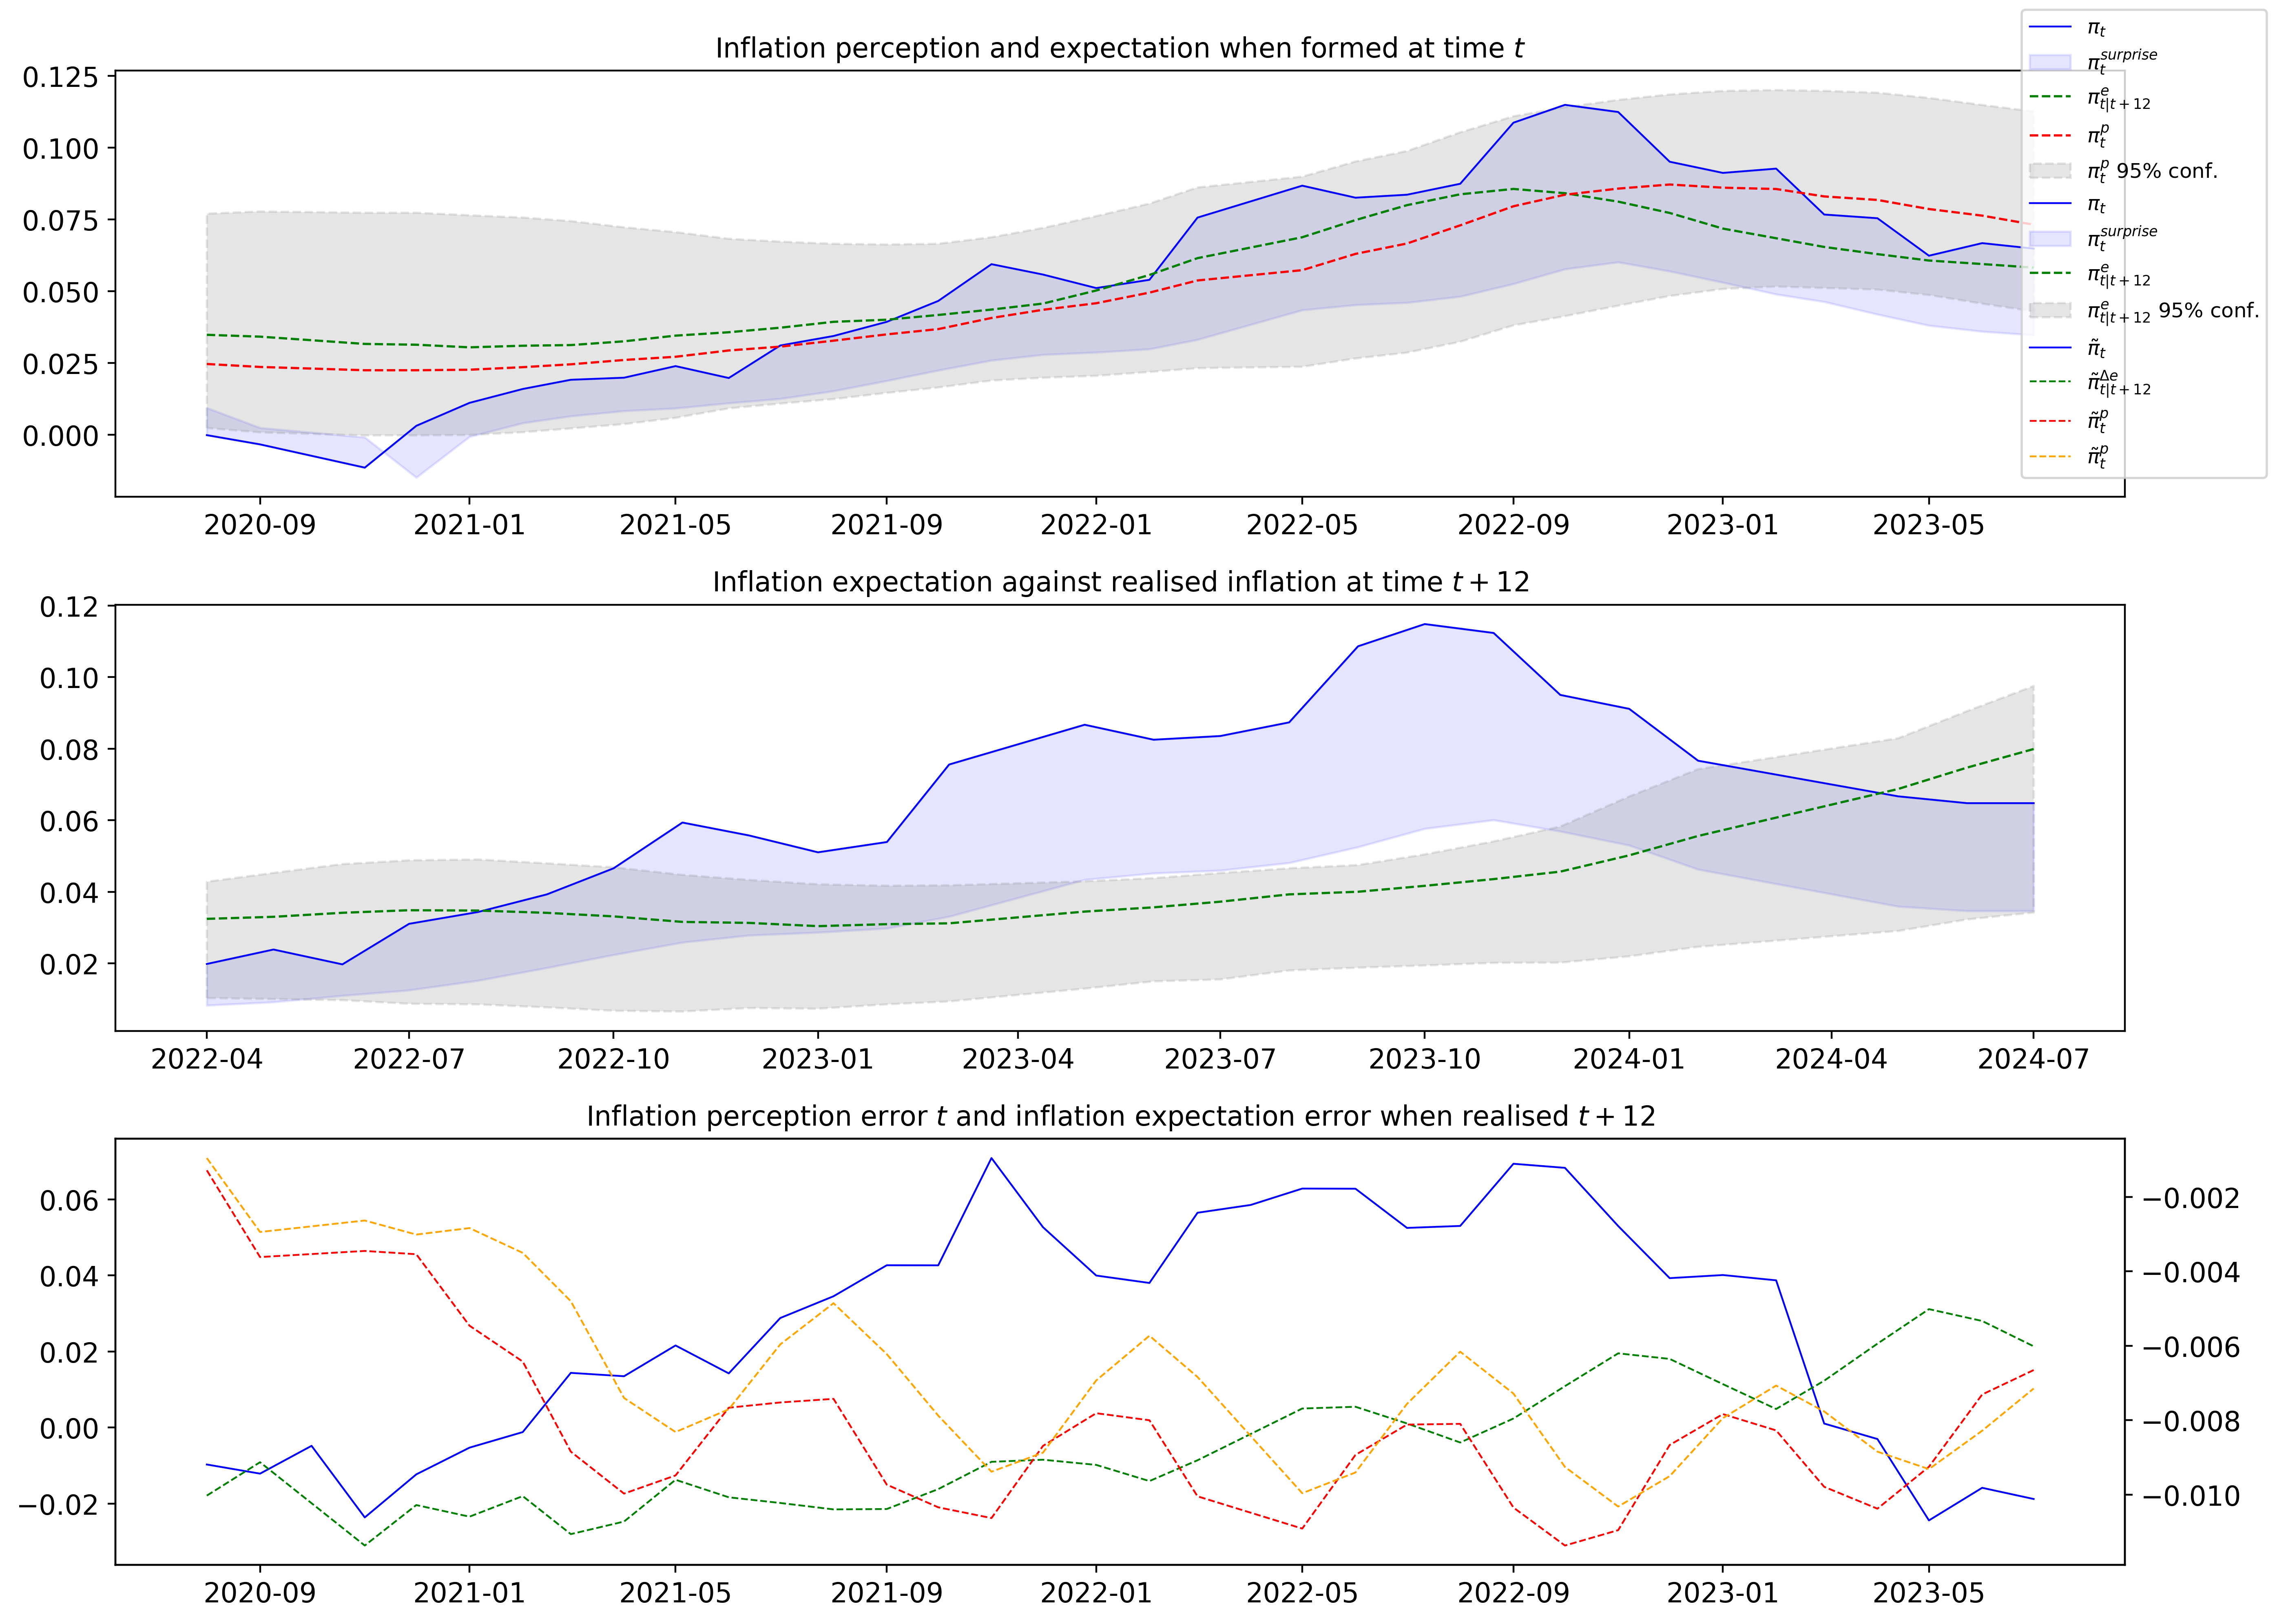

In [83]:
fig, ax = plt.subplots(3,1, figsize=(14,10), dpi=400)

ax[0].plot(sub['pi_de_Y'], color='blue', lw=.8, label='$\pi_t$')
ax[0].fill_between(sub.index, sub['pi_de_estimate_Y'], sub['pi_de_Y'], color='blue', alpha=.1, label="$\pi^{surprise}_t$",)

ax[0].plot(sub['pi_exp_MY'], color='green', linestyle='dashed', lw=1, label=r'$\pi^e_{t|t+12}$')
ax[0].plot(sub['pi_perc_MY'], linestyle='dashed', color='red', lw=1, label=r'$\pi^p_{t}$')
ax[0].fill_between(sub.index, sub['pi_perc95_MY'], sub['pi_perc05_MY'], color='grey', linestyle='dashed',
                alpha=.2, label='$\pi^p_{t}$ 95% conf.')

ax[0].set_title('Inflation perception and expectation when formed at time $t$', size=12)

ax[1].plot(sub2['pi_de_Y'], color='blue', lw=.8, label='$\pi_t$')
ax[1].fill_between(sub2.index, sub2['pi_de_estimate_Y'], sub2['pi_de_Y'], color='blue', alpha=.1, label="$\pi^{surprise}_t$",)
ax[1].plot(sub2['pi_exp_MY_F'], color='green', linestyle='dashed', lw=1, label=r'$\pi^e_{t|t+12}$')
ax[1].fill_between(sub2.index, sub2['pi_exp975_MY_F'], sub2['pi_exp025_MY_F'], color='grey', linestyle='dashed',
                alpha=.2, label='$\pi^e_{t|t+12}$ 95% conf.')
ax[1].set_title("Inflation expectation against realised inflation at time $t+12$", size=12)

_pi = pi.loc[sub.index.min(): sub.index.max()].copy()
ax[2].plot(_pi['pi_de_Y_diff'], color='blue', lw=.8, label='$\~{\pi}_t$')
ax[2].plot(sub['delta_pe_MY_error_act']/100, lw=.8, color='green', linestyle='dashed', label='$\~{\pi}^{\Delta e}_{t|t+12}$')
ax[2].set_title("Inflation perception error $t$ and inflation expectation error when realised $t+12$", size=12)

ax22 = ax[2].twinx()
ax22.plot(sub['pi_perc_MY_error_act']/100, lw=.8, color='red', linestyle='dashed', label='$\~{\pi}^{p}_t$')
ax22.plot(sub['pi_perc_MY__S_error_act']/100, lw=.8, color='orange', linestyle='dashed', label='$\~{\pi}^{p}_t$')

fig.legend(prop={'size': 9})
fig.tight_layout()

save_fig(fig, 'plot_inflation.png')

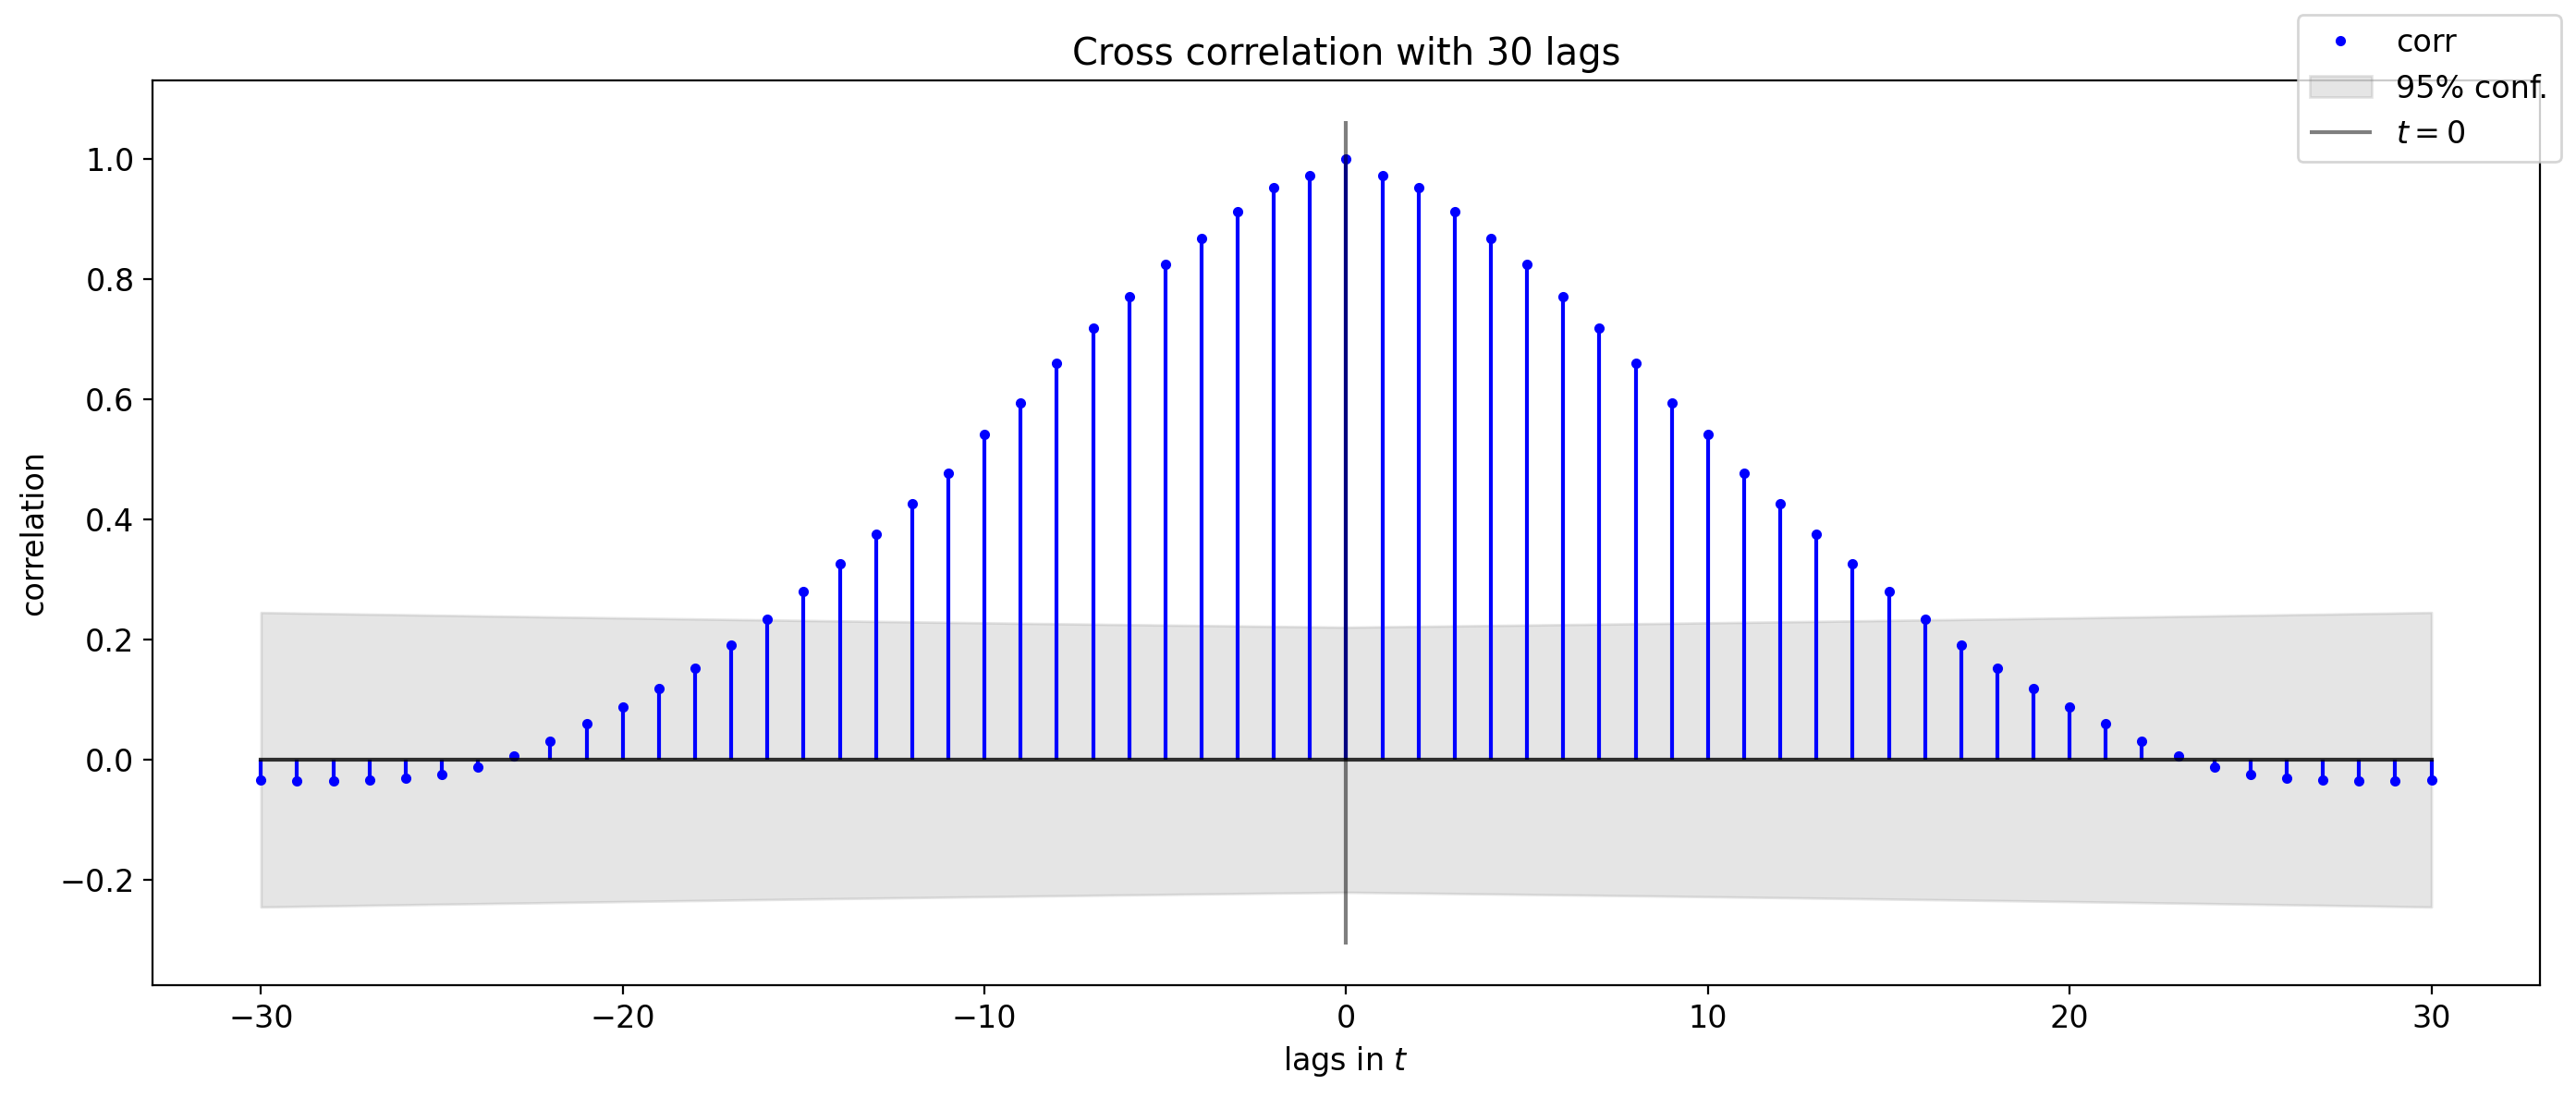

In [18]:
xcorr(pi.pi_de_estimate_Y.dropna(), n_lags=30);

## overview on news and narratives

In [19]:
sub = topics.drop(['M_policy',], axis=1).drop_duplicates().copy().drop('date', axis=1) #.iloc[:300]

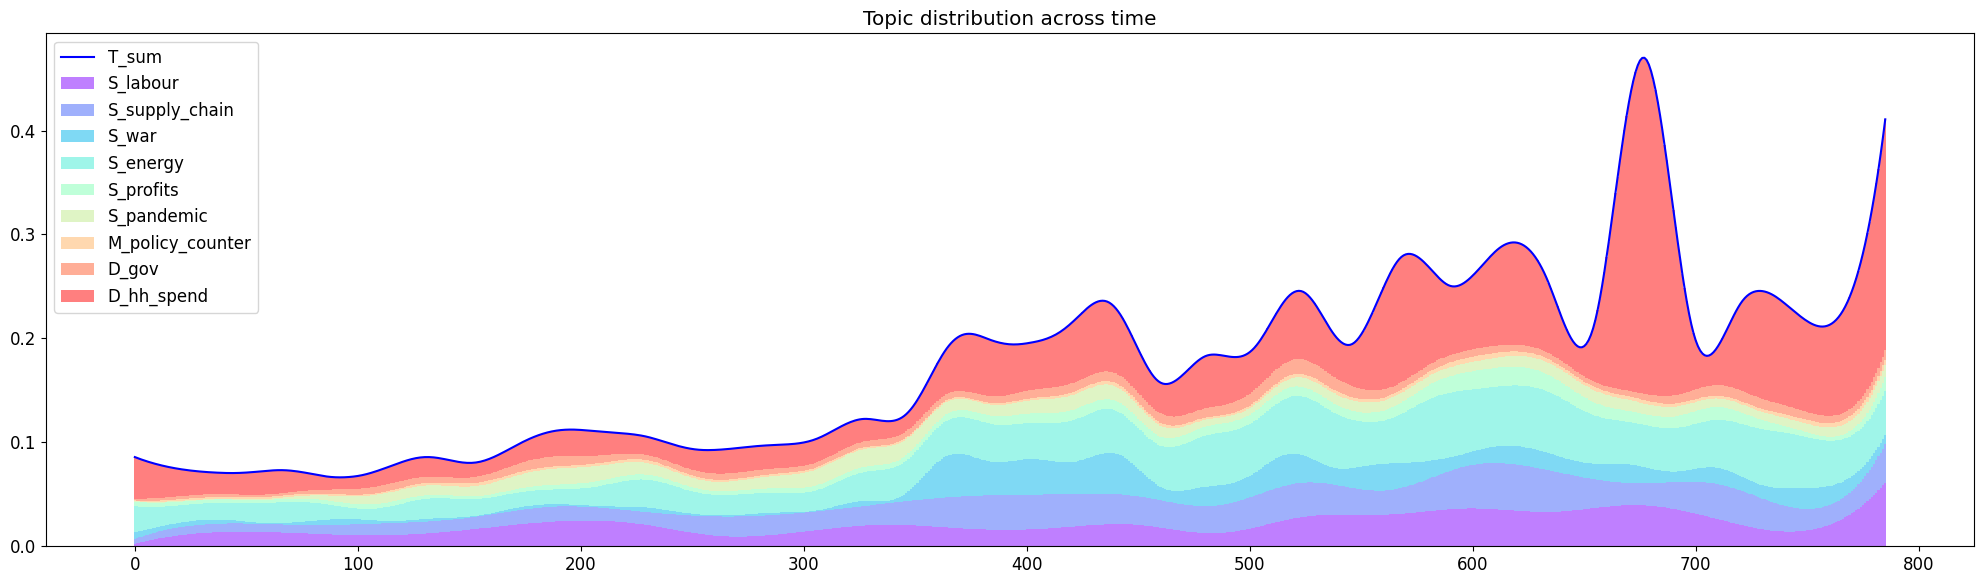

In [20]:
fig, ax = plt_stacked_bar(sub.drop(['D_inflation', 'T_sum', 'T_sum_diff_lag', 'T_sum_diff_lag_M'], axis=1), )

ax.plot(sub.T_sum.values, color='blue', label='T_sum')
ax.set_title("Topic distribution across time")
ax.legend(loc="upper left")
fig.tight_layout()
save_fig(fig, "topics_time.png")

### media and BEI

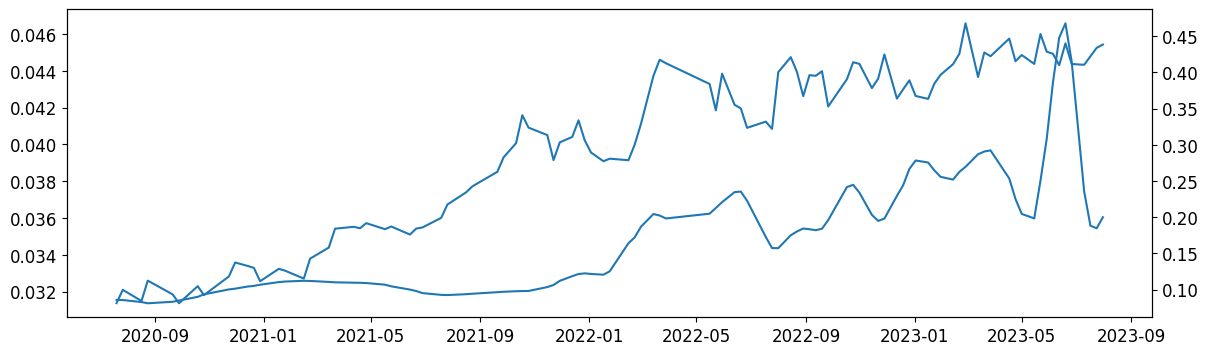

In [21]:
sub = df[['week_recorded', 'bei', 'T_sum']].groupby('week_recorded').last().dropna().copy()
fig, ax = get_fig_subplots()
ax.plot(sub.bei)
ax.twinx().plot(sub.T_sum)

### war and inflation as given by hh concern

In [22]:
sub = df[['week_recorded', 'percprob_war', 'percprob_covid']].copy().dropna()
sub = sub.groupby('week_recorded').mean()
sub = pd_join_freq(sub, topics[['S_war', 'S_pandemic']].drop_duplicates() * 500, 'W', keep_left_index=False)
sub = sub.loc[~sub.index.duplicated()]

cols_endog, cols_exog = ['S_war'], ['percprob_war']
_dict = {'percprob_war': 'War perceived', 'percprob_covid': 'Covid-19 perceived', 'S_war': 'War report', 'S_pandemic': 'Covid-19 report'}

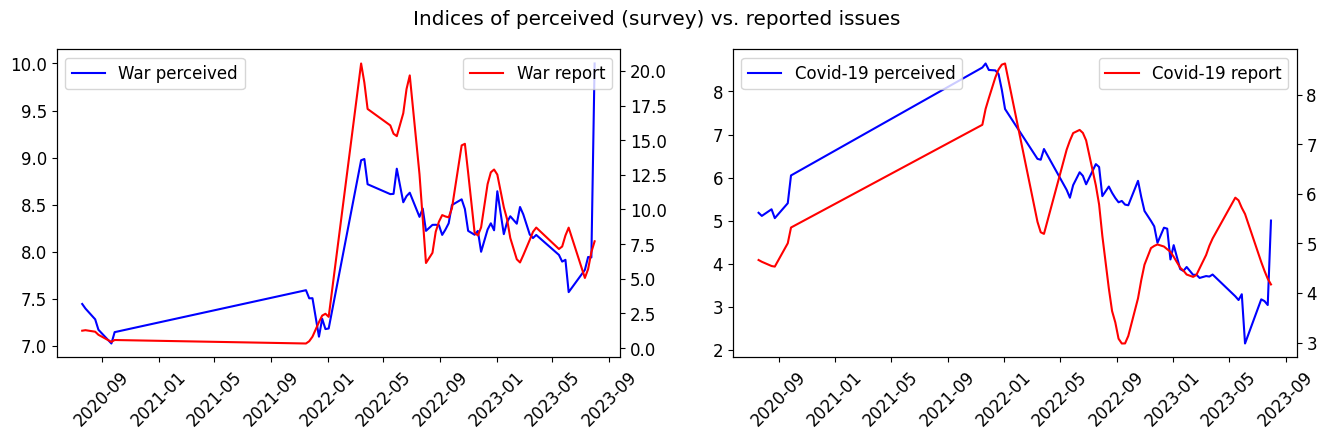

In [23]:
fig, axes = get_fig_subplots(2,2, figsize=(16,2))
lst_cols = [('percprob_war', 'S_war'), ('percprob_covid', 'S_pandemic')]
for idx, ax in enumerate(axes):
    ax.plot(sub[lst_cols[idx][0]], label=_dict[lst_cols[idx][0]], color='blue')
    ax2 = ax.twinx()
    ax2.plot(sub[lst_cols[idx][1]], label=_dict[lst_cols[idx][1]], color='red')
    ax2.legend(loc='upper right')
    ax.legend(loc='upper left')
    ax.tick_params(axis='x', rotation=45)
# axes[0].legend([
fig.suptitle("Indices of perceived (survey) vs. reported issues")
save_fig(fig, "topics_percprob.png")

In [24]:
sub = pd_groupby(df.set_index('date_recorded'), 
                 ['pi_de_surprise_Y', 'delta_pe_MY', 'pi_perc_MY_error_act', 'pi_de_estimate_Y', 'pi_exp_MY', 'pi_perc_MY', 'T_sum']
                 , 'M', 'last').dropna()
sub = pd_join_freq(sub,
             pd_groupby(df.set_index('date_recorded'), ['delta_pe_MY_error_act_MY', 'pi_perc_uncertainty_MY',], 'M', 'mean'),
             'M',
            )
sub['pi_perc_MY_error_act'] /= 100
sub['delta_pe_MY_error_act_MY'] /= 10

## plot errors

In [ ]:
fig, axes = get_fig_subplots(3, 3, figsize=(14,1.5))
for i, ax in enumerate(axes):
    ax.set_title(lst_error_cols[i], size=10)
    ax.hist(df[['id', lst_error_cols[i]]].drop_duplicates().drop('id', axis=1).dropna(), color='blue', alpha=.8, density=True)
    ax.set_title(dict_cols_pretty_names[lst_error_cols[i]])
    
fig.suptitle("Expectation and Perception Residuals")
fig.tight_layout();
save_fig(fig, 'emp_error_hist.png')

# Cross Section Expectation and perception

In [19]:
lst_error_cols = sorted([i for i in df.columns if "_error" in i and "mse" not in i and 'all' not in i])
lst_error_cols

['delta_pe_MY_error_act', 'pi_exp_MY_error_act', 'pi_perc_MY_error_act']

In [20]:
for col in lst_error_cols:
    print(col, df[['id', col]].drop_duplicates().dropna().shape)
    # plt.hist(df[['id',col]].drop_duplicates().dropna().iloc[:, 1])

delta_pe_MY_error_act (10748, 2)
pi_exp_MY_error_act (10976, 2)
pi_perc_MY_error_act (9130, 2)


In [21]:
dict_cols_pretty_names = {
    'delta_pe_MY_error_act': "$\~{\pi}^{\Delta e}_{t|t+12}$", 
    "pi_exp_MY_error_act": "$\~{\pi}^e_{t|t+12}$", 
    "pi_perc_MY_error_act": "$\~{\pi}^p_{t}$"
}

In [23]:
_ = df.set_index('id')[lst_error_cols].drop_duplicates()
ols_data = hhp[
    [
        'is_food_shop',  
        # 'pinc_midpoint', 
        'hhinc_midpoint',
        # 'hhinc',
        # 'debt_midpoint',
        # 'eduschool_txt',
        'eduwork_txt',
        # 'wealth_bank_midpoint', 
        'savings_planned', 
        # 'profession_txt',
        # 'ecbtrust',
        # 'pr
        # 'hhsize',
        'riskaversion',
        'hhchildren', 
        # 'is_invest_shop', 
        # 'is_unempl', 
        # 'is_cash_pay',
        # 'is_homeown', 
        'id',
    ]].set_index('id').loc[_.index].copy()
ols_data = ols_data.join(_).reset_index().groupby('id').last()
ols_data2 = ols_data.copy()

In [24]:
DICT_PARSE_COLS.update(
    {
        'hhsize': 'categoryO', 'hhinc_midpoint': float, 'pinc_midpoint': 'categoryO', 'profession_txt': 'category',
        'riskaversion': 'categoryO', 'eduschool_txt': 'category', 'savings_planned': float,
    }
)
DICT_PARSE_COLS.update({i: float for i in lst_error_cols})
ols_data = pd_df_astype(ols_data, DICT_PARSE_COLS)

In [25]:
dict_cat_cols = {}
for col in ols_data:
    if ols_data[col].dtype == 'category':
        dummies = pd.get_dummies(ols_data[col].dropna(), dtype=bool, )
        dummies = dummies.add_prefix(col)
        ols_data = ols_data.join(dummies.iloc[:, :])
        ols_data = ols_data.drop(col, axis=1)
        
ols_data['const'] = np.ones(len(ols_data))
ols_data = ols_data.drop_duplicates().astype(float)

In [26]:
# multiple ols models
lst_ols_mods, lst_dfbetas, lst_ols_data = [], [], []
_ = ""
for col in lst_error_cols + ['delta_pe_MY_error_act']:
    d = ols_data.drop([i for i in lst_error_cols if i != col], axis=1)
    
    if col == "delta_pe_MY_error_act" and _ == "":
        d = d #[[i for i in d.columns if i not in ['hhsize']]] #', 'is_unempl']]]
        _ = "x"
    else:
        d = d[[i for i in d.columns if 'risk' not in i]]
    d = d.dropna()
    ols = OLS(
        d[col], 
        d.drop(col, axis=1),
        hasconst=True,
    ).fit()
    
    lst_ols_data.append((d[col], d.drop(col, axis=1)))
    # dfbeta = get_dfbetas(ols.model.exog, ols.resid.values)
    # lst_dfbetas.append((d, pd.DataFrame(dfbeta, index=d.index, columns=d.columns[:-1])))
    lst_ols_mods.append(ols)

In [27]:
out = get_statsmodels_summary(lst_ols_mods, seperator=" ", is_filt_sig=True)
save_pd_df(out, 'tab_cross_section_error.csv', GRAPHS_DIR)

In [28]:
out

,delta_pe_MY_error_act,delta_pe_MY_error_act_3,pi_exp_MY_error_act,pi_perc_MY_error_act
eduwork_txtanderer Abschluss,-1.772 ** [-2.533],-0.219 [-0.748],-0.171 [-0.822],0.068 [1.152]
riskaversion8.0,0.729 ** [2.24],NaN,NaN,NaN
is_food_shop,0.941 * [1.864],-0.12 [-0.582],0.097 [0.681],0.106 *** [2.61]
hhchildren3.0,-0.033 [-0.066],-0.273 [-1.088],-0.277 [-1.58],-0.15 *** [-2.993]
hhchildren2.0,0.044 [0.128],-0.068 [-0.434],-0.167 [-1.519],-0.185 *** [-5.778]
hhchildren1.0,-0.327 [-1.121],0.055 [0.387],-0.068 [-0.686],-0.166 *** [-5.778]
hhchildren0.0,-0.138 [-0.654],0.09 [0.905],-0.073 [-1.055],-0.2 *** [-10.091]
riskaversion9.0,0.864 ** [2.029],NaN,NaN,NaN
savings_planned,0.022 [0.105],0.298 *** [3.059],0.197 *** [2.886],0.042 ** [2.127]
eduwork_txtMaster abgeschlossen,-0.48 * [-1.729],-0.114 [-0.842],-0.137 [-1.454],-0.086 *** [-3.121]


## risk aversion delta_pe

In [29]:
sub2 = get_statsmodels_summary(lst_ols_mods, ['conf_upper', 'conf_lower', 'coef']).copy()
sub2 = sub2.swaplevel(axis=1)['delta_pe_MY_error_act'].loc[[i for i in sub2.index if 'risk' in i]]
sub2.index = [int(float(i.split('riskaversion')[-1])) for i in sub2.index]

sub = ols_data2.loc[~ols_data2.riskaversion.isna()].copy()
sub = sub[['delta_pe_MY_error_act', 'riskaversion']].dropna()
mean = sub.delta_pe_MY_error_act.mean()
sub = sub.groupby('riskaversion', observed=True).aggregate(['mean', 'std']).droplevel(0, axis=1)
sub.index = [int(float(i)) for i in sub.index]

sub = sub.join(sub2)

In [30]:
sub3 = df[['id', 'riskaversion', 'savings_planned']].dropna().copy()
sub3['savings_planned'] = sub3['savings_planned'].replace({1: 0}) * -1

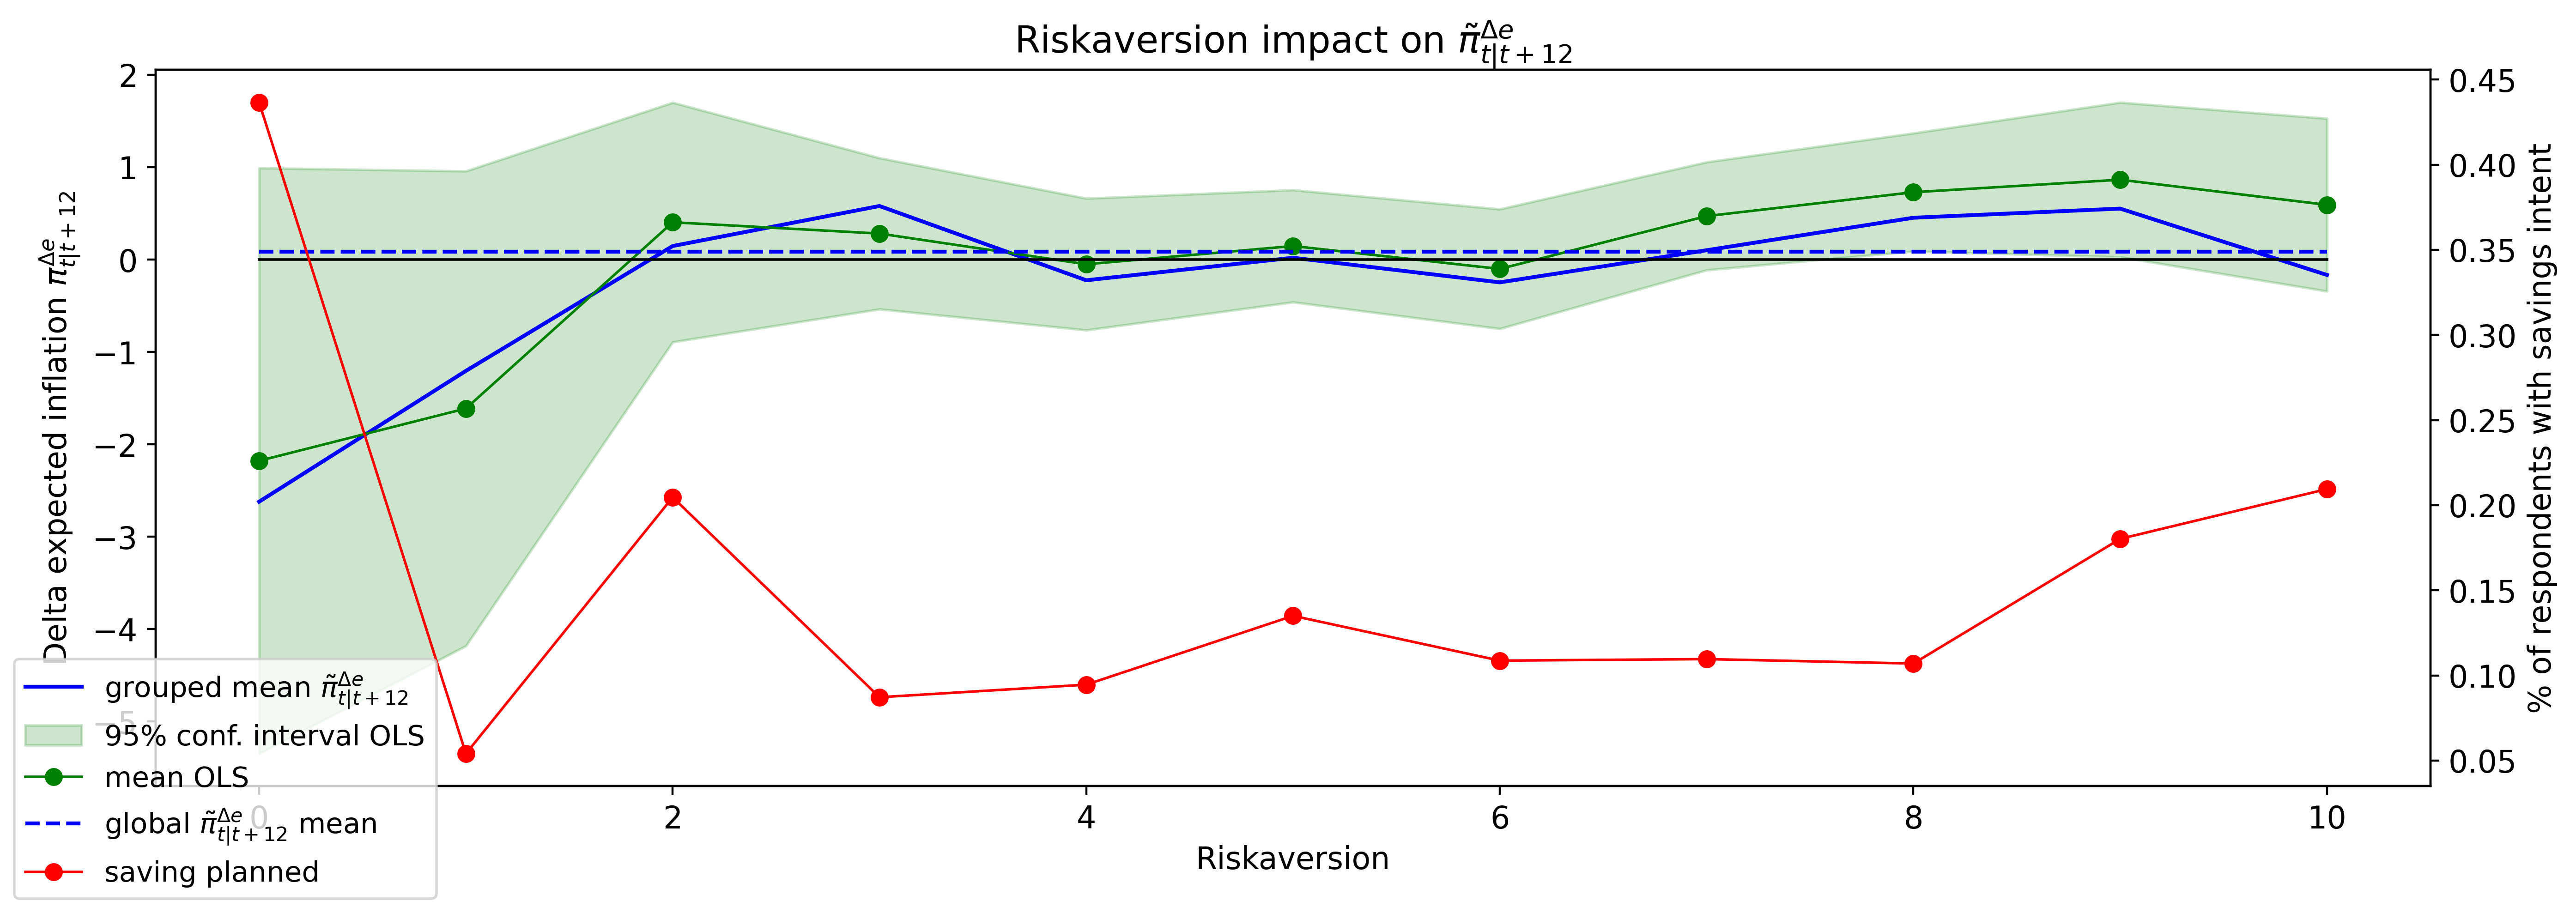

In [31]:
fig, ax = get_fig_subplots(figsize=(14,5), dpi=400)
ax.plot(sub['mean'], color='blue', label='grouped mean $\~{\pi}^{\Delta e}_{t|t+12}$')
ax.fill_between(sub.index, sub['conf_lower'], sub['conf_upper'], color='green', alpha=.2, label='95% conf. interval OLS')
ax.plot(sub['coef'], lw=1, marker='o', color='green', label='mean OLS')
ax.plot(sub.index, list([0] * len(sub2)), color='black', lw=1,)
ax.plot(sub.index, list([mean] * len(sub)), label='global $\~{\pi}^{\Delta e}_{t|t+12}$ mean', color='blue', linestyle='dashed')

ax2 = ax.twinx()
ax2.plot(sub3.groupby('riskaversion').savings_planned.mean(), color='red', lw=1, marker='o', label='saving planned')

ax.set_xlabel("Riskaversion")
ax2.set_ylabel("% of respondents with savings intent")
ax.set_ylabel("Delta expected inflation $\pi^{\Delta e}_{t|t+12}$")
ax.set_title("Riskaversion impact on $\~{\pi}^{\Delta e}_{t|t+12}$")

fig.legend(loc='lower left', prop={'size': 11})

fig.tight_layout()
save_fig(fig, "riskaversion.png", GRAPHS_DIR)

# Macro Time Series Error analysis

## Test errors in time series dimension

In [32]:
for col in [('recorded', 'delta_pe_MY_error_act'), ('recorded', 'pi_perc_MY_all_error_act')]:

    sub = df[[f'date_{col[0]}', f'week_{col[0]}', 'id', col[1]]].drop_duplicates().dropna().groupby(f'week_{col[0]}')[col[1]].median().copy()
    sub /= 100
    df = pd_join_freq(df.set_index('date_recorded'), pd.DataFrame(sub.rename(f'{col[1]}_WY')), 'W', keep_left_index=True).copy()
    df = pd_join_freq(df, 
                     pd_groupby(pd.DataFrame(sub.rename(f'{col[1]}_MY')), [f'{col[1]}_MY'], 'M', 'last'),
                     'M', keep_left_index=True)
df = df.reset_index(drop=True)

In [33]:
df.T_sum_diff_lag

0         0.000217
1         0.000135
2         0.000217
3         0.000135
4         0.000217
            ...   
595519    0.001226
595520    0.001977
595521    0.002619
595522    0.003154
595523    0.003591
Name: T_sum_diff_lag, Length: 595524, dtype: float64

In [34]:
sub = df.set_index('date_recorded')[
    ['delta_pe_MY_error_act_MY', 'pi_perc_MY_all_error_act_MY', 'pi_de_surprise_Y', 'pi_de_Y',]
].drop_duplicates()
sub2 = df.set_index('date_recorded')[
    ['delta_pe_MY_error_act_WY', 'pi_perc_MY_all_error_act_WY', 'T_sum_diff_lag']
].drop_duplicates()

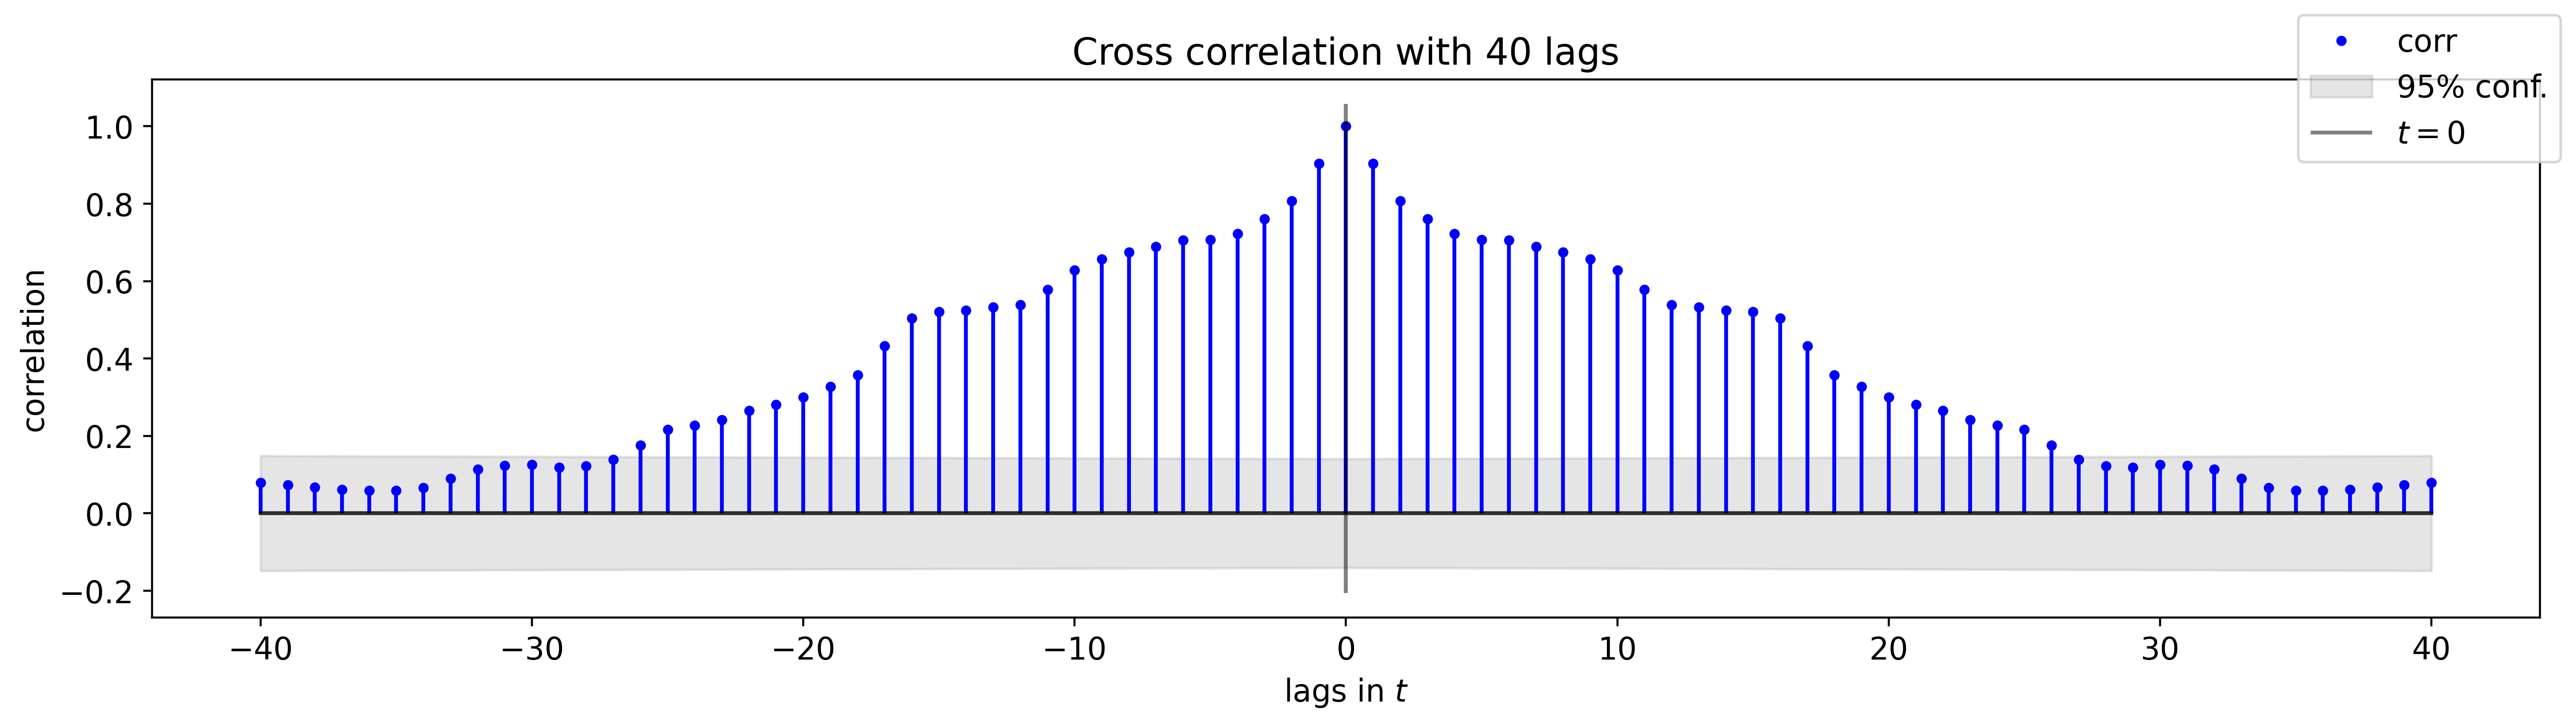

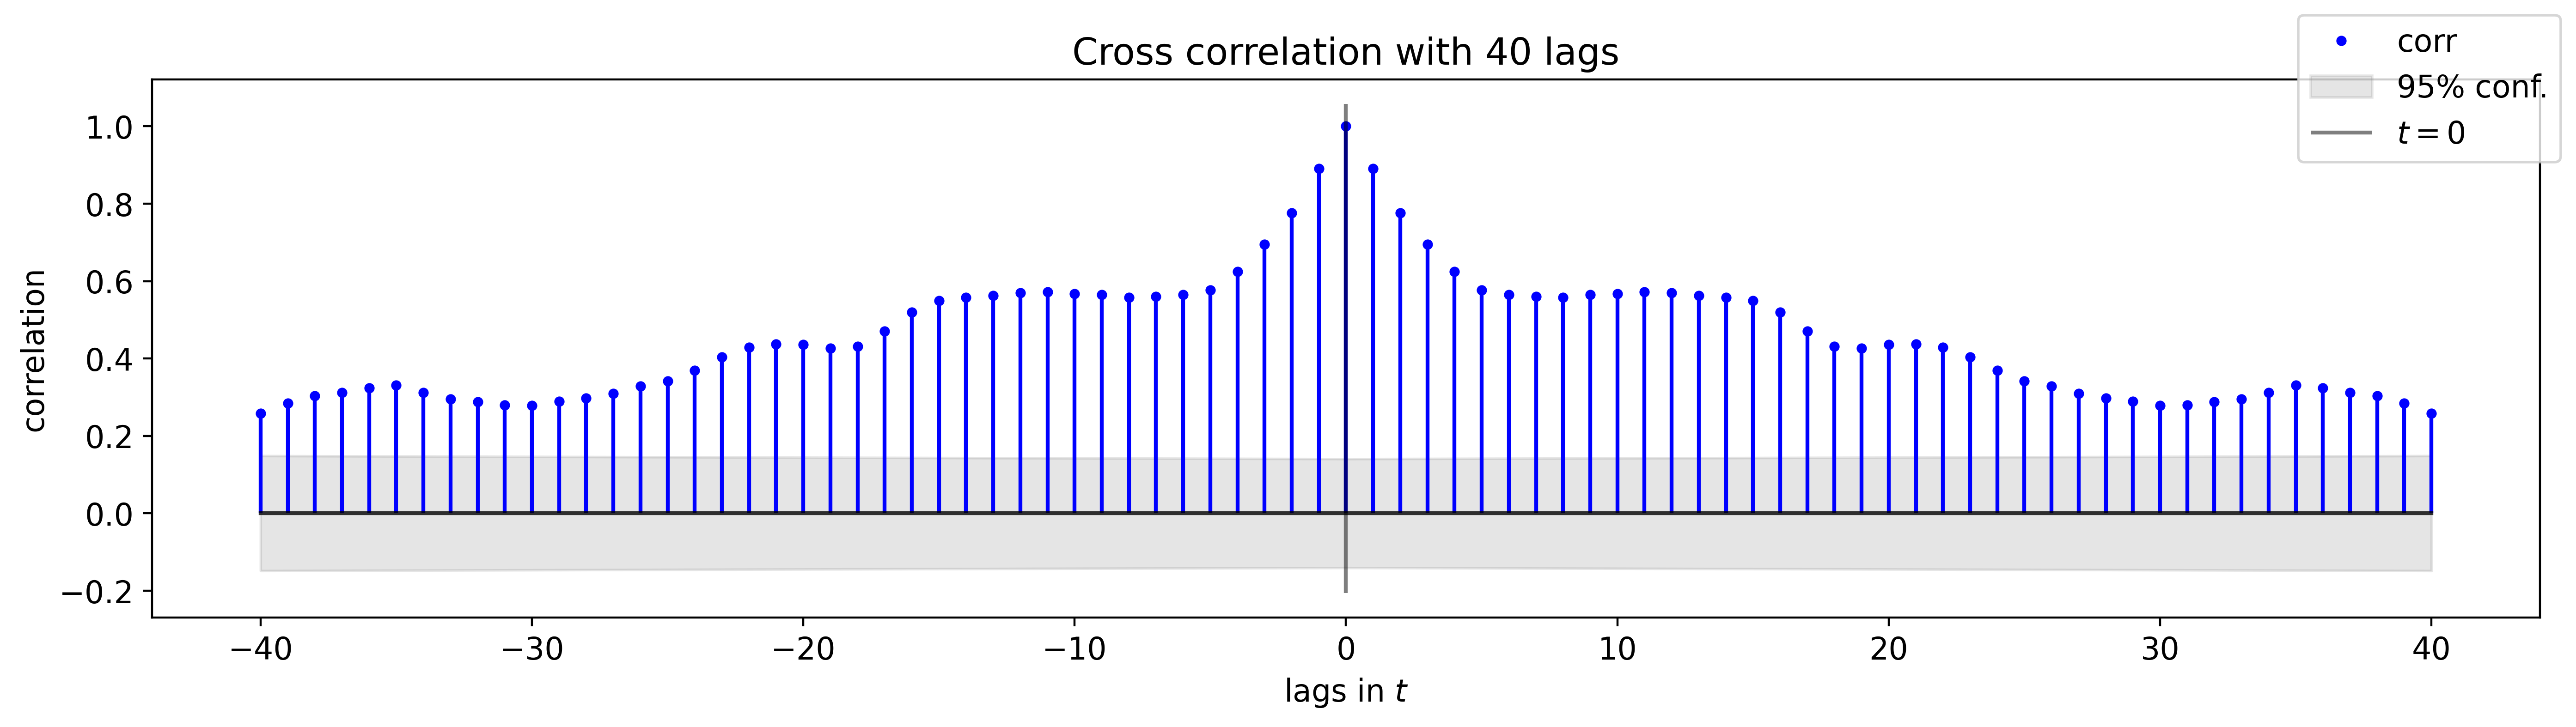

In [35]:
_, _, _, fig = xcorr(sub2.pi_perc_MY_all_error_act_WY, dpi=400, n_lags=40, figsize=(14,4));
fig, ax = fig
save_fig(fig, 'emp_pi_perc_acorr.png')
_, _, _, fig = xcorr(sub2.delta_pe_MY_error_act_WY, dpi=400, n_lags=40, figsize=(14,4));
fig, ax = fig
save_fig(fig, 'emp_delta_pe_acorr.png')

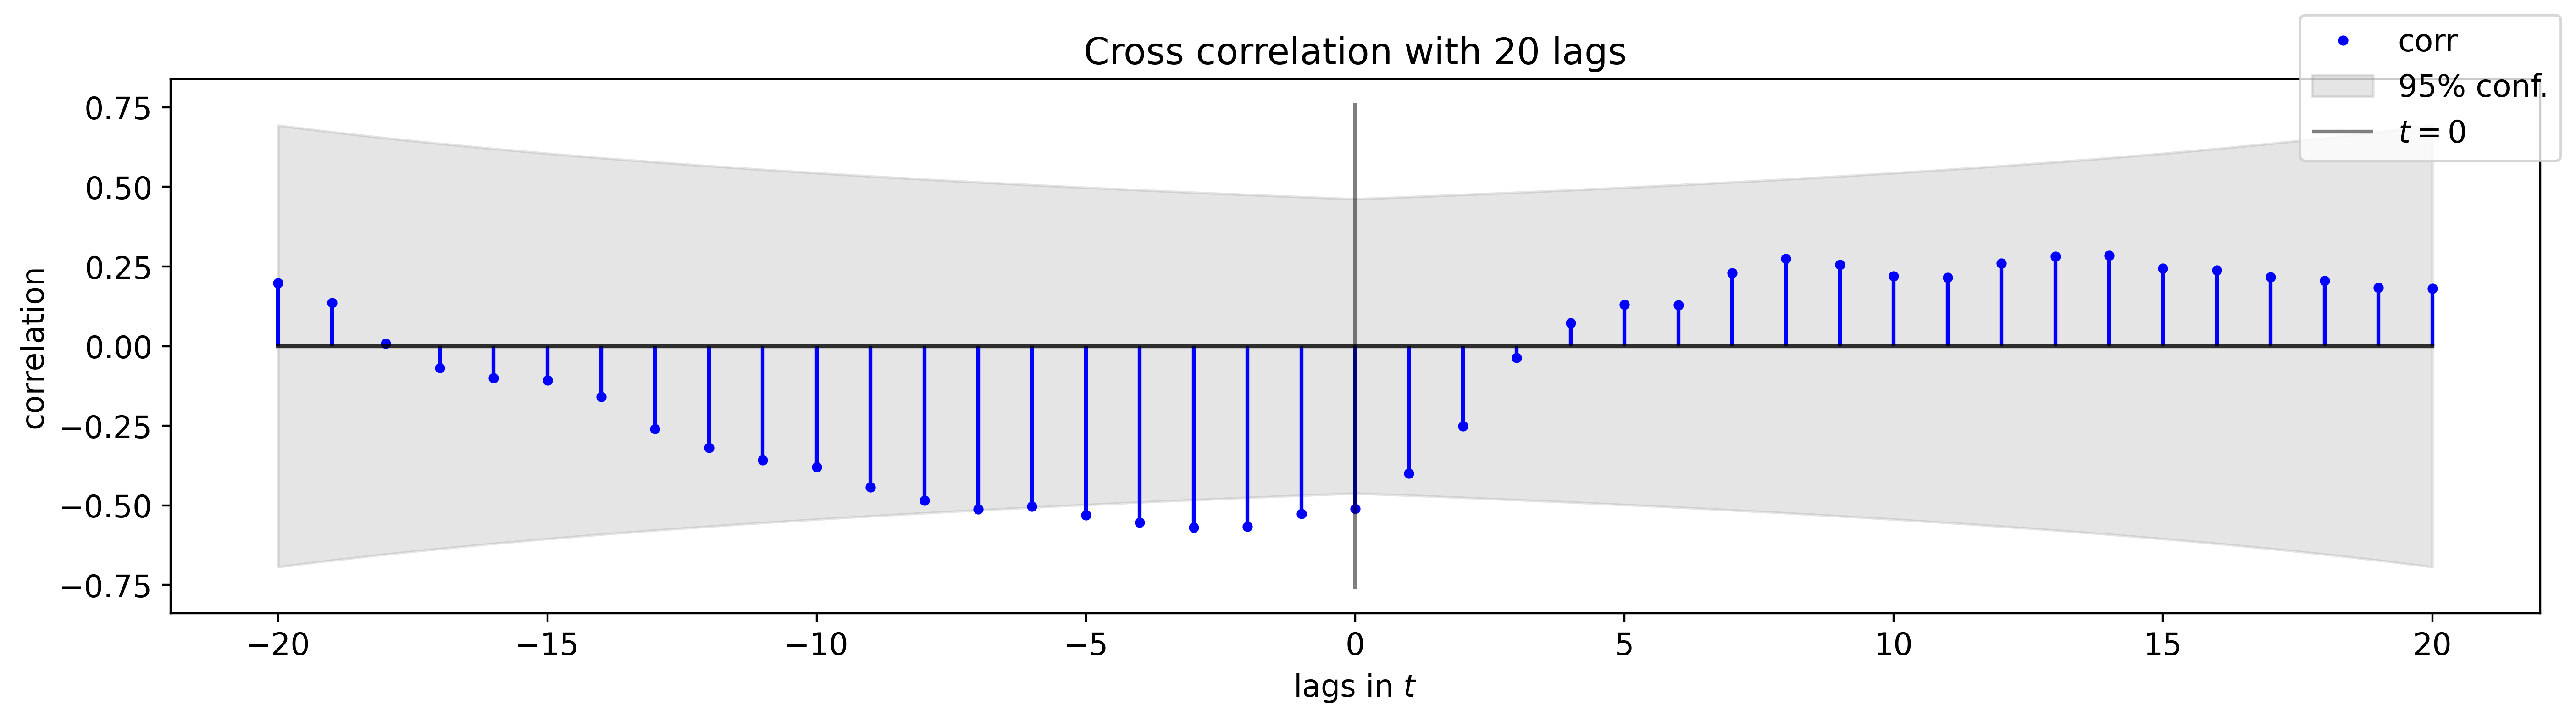

In [36]:
_, _, _, fig = xcorr(sub.pi_perc_MY_all_error_act_MY, sub.pi_de_Y, n_lags=20, dpi=400, figsize=(14,4))
fig, ax = fig
save_fig(fig, 'emp_pi_pe_real_xcorr.png')

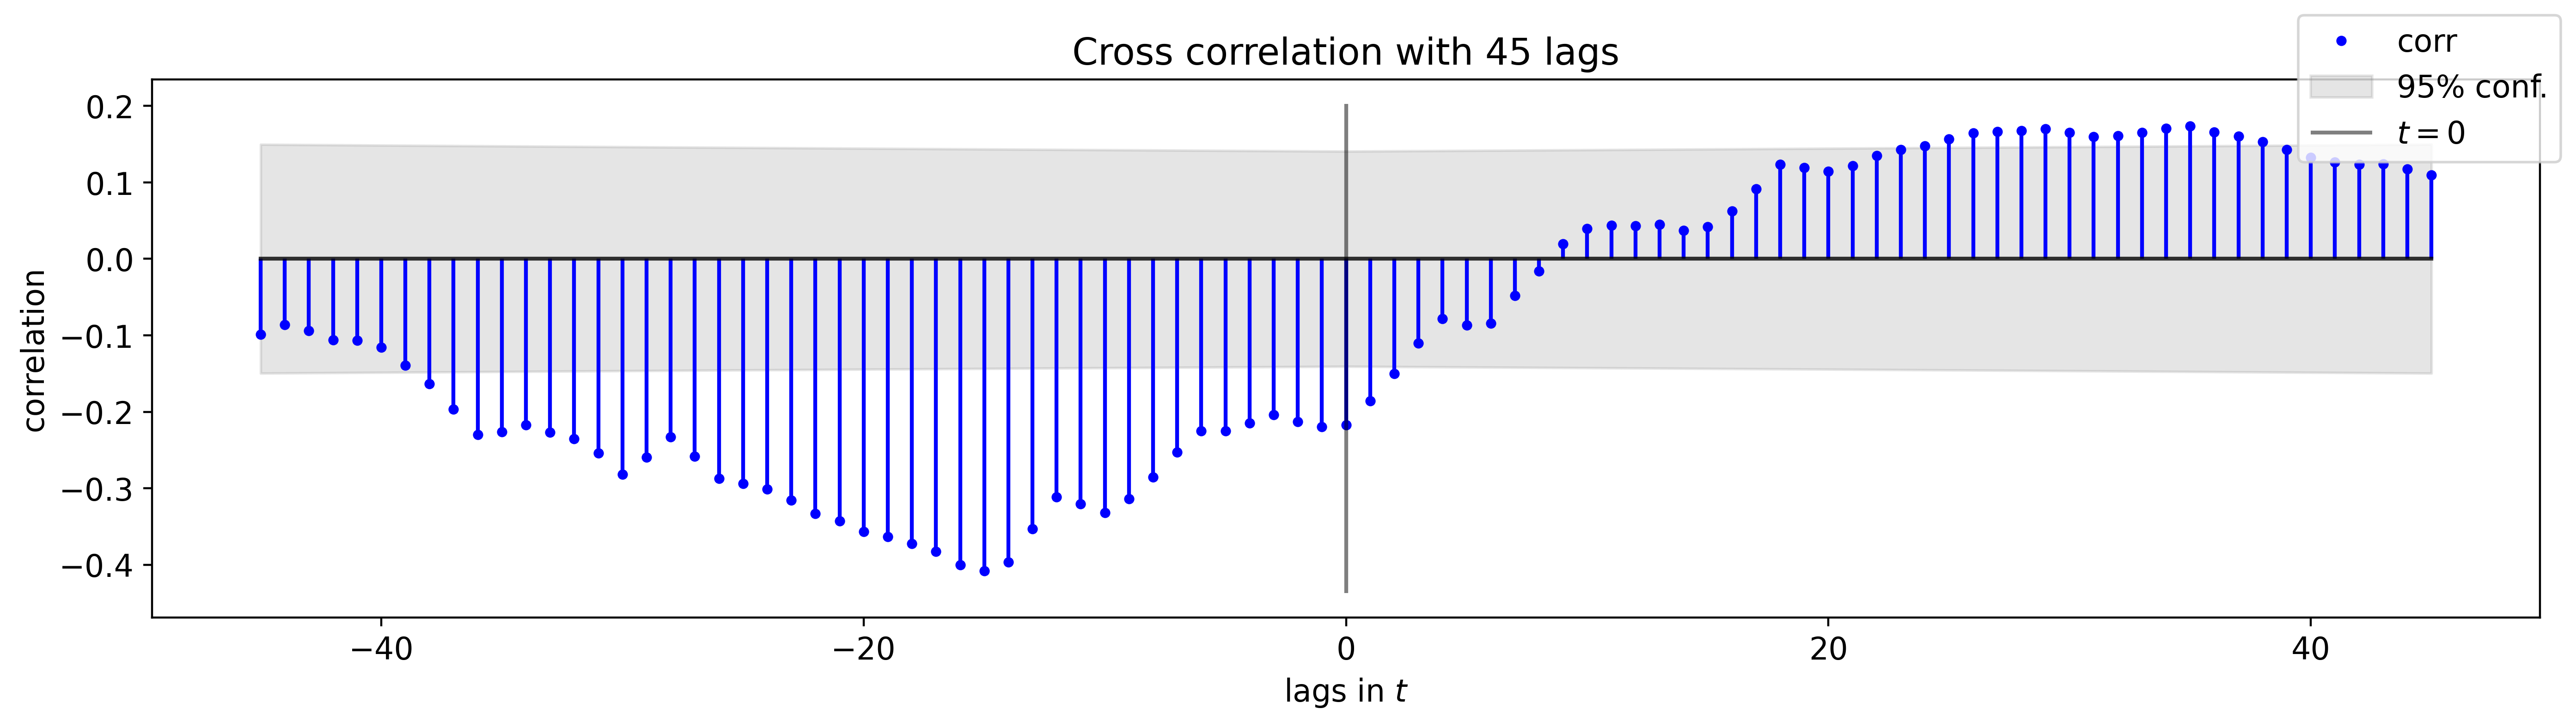

In [37]:
_, _, _, fig = xcorr(sub2.pi_perc_MY_all_error_act_WY, sub2.delta_pe_MY_error_act_WY, n_lags=45,  dpi=400, figsize=(14,4))
fig, ax = fig
save_fig(fig, 'emp_pi_pe_delta_xcorr.png')

In [38]:
# _, _, _, fig = xcorr(sub2.pi_perc_MY_all_error_act_WY, sub2.T_sum_diff_lag, dpi=400, figsize=(14,4))
# fig, ax = fig
# save_fig(fig, 'emp_pi_pe_delta_xcorr.png')

## VECM error, perceived and expexcted

### pi perc

In [39]:
sub = pd_join_freq(df.groupby('month_recorded')[['pi_perc_MY', 'delta_pe_MY']].last().dropna().drop_duplicates(),
                   pi[['pi_de_surprise_Y', 'pi_de_Y', 'pi_de_estimate_Y',]],
                   'M', keep_left_index=False).drop_duplicates().dropna()

In [40]:
cols_endog, cols_exog = ['pi_perc_MY'], ['pi_de_surprise_Y', 'pi_de_estimate_Y', 'delta_pe_MY']

In [41]:
for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 5) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=3)
print(var_order.aic, var_order.bic)

vecm1 = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=var_order.aic).fit()
# vecm1.summary()

pi_perc_MY ADF p-val: 0.018553484289268035
pi_de_surprise_Y ADF p-val: 0.11372717523909132
pi_de_estimate_Y ADF p-val: 0.19485770440830852
delta_pe_MY ADF p-val: 0.44313200381795326
4
3 1


C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\statsmodels\tsa\vector_ar\vecm.py:731: RuntimeWarning: invalid value encountered in log
  tmp = np.log(iota - a)[i:]
C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\statsmodels\tsa\vector_ar\vecm.py:733: RuntimeWarning: invalid value encountered in log
  lr2[i] = -t * np.log(1 - a[i])


In [42]:
# vecm1.irf(periods=5).plot()
# plt.tight_layout()
# ;

### pi perc error

In [43]:
sub = pd_join_freq(df.groupby('month_recorded')[['pi_perc_MY_all_error_act_MY', 'delta_pe_MY']].last().dropna().drop_duplicates(),
                   pi[['pi_de_surprise_Y', 'pi_de_Y', 'pi_de_estimate_Y']],
                   'M', keep_left_index=False).drop_duplicates().dropna()
# sub.plot()

In [44]:
cols_endog, cols_exog = ['pi_perc_MY_all_error_act_MY'], ['pi_de_surprise_Y', 'pi_de_estimate_Y', 'delta_pe_MY']
var2 = VAR(sub[cols_endog + cols_exog].diff().dropna(),).fit(maxlags=2, ic='fpe')
# print(var1.summary())

In [45]:
for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 3) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=4)
print(var_order.aic, var_order.bic)

vecm2 = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=var_order.aic).fit()
# vecm2.summary()

pi_perc_MY_all_error_act_MY ADF p-val: 0.007149099843482691
pi_de_surprise_Y ADF p-val: 0.10964410772978911
pi_de_estimate_Y ADF p-val: 0.5890090275327853
delta_pe_MY ADF p-val: 0.5619457365131322
2
4 4


### delta exp

In [46]:
sub = pd_join_freq(df.groupby('month_recorded')[['delta_pe_MY', 'pi_perc_MY']].last().dropna().drop_duplicates(),
                   pi[['pi_de_surprise_Y', 'pi_de_Y', 'pi_de_estimate_Y']],
                   'M', keep_left_index=False).drop_duplicates().dropna()
# sub.plot()

In [47]:
cols_endog, cols_exog = ['delta_pe_MY'], ['pi_de_surprise_Y', 'pi_de_estimate_Y', 'pi_perc_MY']

for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 3) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=4)
print(var_order.aic, var_order.bic)

vecm3 = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=var_order.aic).fit()
# vecm3.summary()

delta_pe_MY ADF p-val: 0.44313200381795326
pi_de_surprise_Y ADF p-val: 0.11372717523909132
pi_de_estimate_Y ADF p-val: 0.19485770440830852
pi_perc_MY ADF p-val: 0.018553484289268035
1
4 4


In [48]:
# vecm3.irf().plot()
# plt.tight_layout();

### delta exp error

In [49]:
sub = pd_join_freq(df.groupby('month_recorded')[['delta_pe_MY_error_act_MY', 'pi_perc_MY']].last().dropna().drop_duplicates(),
                   pi[['pi_de_surprise_Y', 'pi_de_Y', 'pi_de_estimate_Y']],
                   'M', keep_left_index=False).drop_duplicates().dropna()
# sub.plot()

In [50]:
cols_endog, cols_exog = ['delta_pe_MY_error_act_MY'], ['pi_de_surprise_Y', 'pi_de_estimate_Y', 'pi_perc_MY']
for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 3) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=3)
print(var_order.aic, var_order.bic)

vecm4 = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=var_order.aic).fit()
# vecm4.summary()

delta_pe_MY_error_act_MY ADF p-val: 0.020658890361074964
pi_de_surprise_Y ADF p-val: 0.10964410772978911
pi_de_estimate_Y ADF p-val: 0.5890090275327853
pi_perc_MY ADF p-val: 0.01874377846322591
2
1 1


### uncertainty

In [51]:
sub = pd_join_freq(df.groupby('month_recorded')[['pi_perc_uncertainty_MY', 'pi_perc_MY', 'delta_pe_MY']].last().dropna().drop_duplicates(),
                   pi[['pi_de_surprise_Y', 'pi_de_Y', 'pi_de_estimate_Y']],
                   'M', keep_left_index=False).drop_duplicates().dropna()
# sub.plot()

In [52]:
cols_endog, cols_exog = ['pi_perc_uncertainty_MY'], ['pi_de_surprise_Y', 'pi_de_estimate_Y',  'pi_perc_MY', 'delta_pe_MY']
for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 6) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=3)
print(var_order.aic, var_order.bic)

vecm5 = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=var_order.aic).fit()
# vecm5.summary()

pi_perc_uncertainty_MY ADF p-val: 0.0006861008216353449
pi_de_surprise_Y ADF p-val: 0.11372717523909132
pi_de_estimate_Y ADF p-val: 0.19485770440830852
pi_perc_MY ADF p-val: 0.018553484289268035
delta_pe_MY ADF p-val: 0.44313200381795326
1
3 0


In [53]:
# vecm5.irf().plot()
# plt.tight_layout();

### summary

In [54]:
lst_vecms1 = [vecm1, vecm2, vecm3, vecm4, vecm5]
out = get_statsmodels_summary(lst_vecms1, is_filt_sig=True)
save_pd_df(out, 'tab_vecm_resid.csv', GRAPHS_DIR)

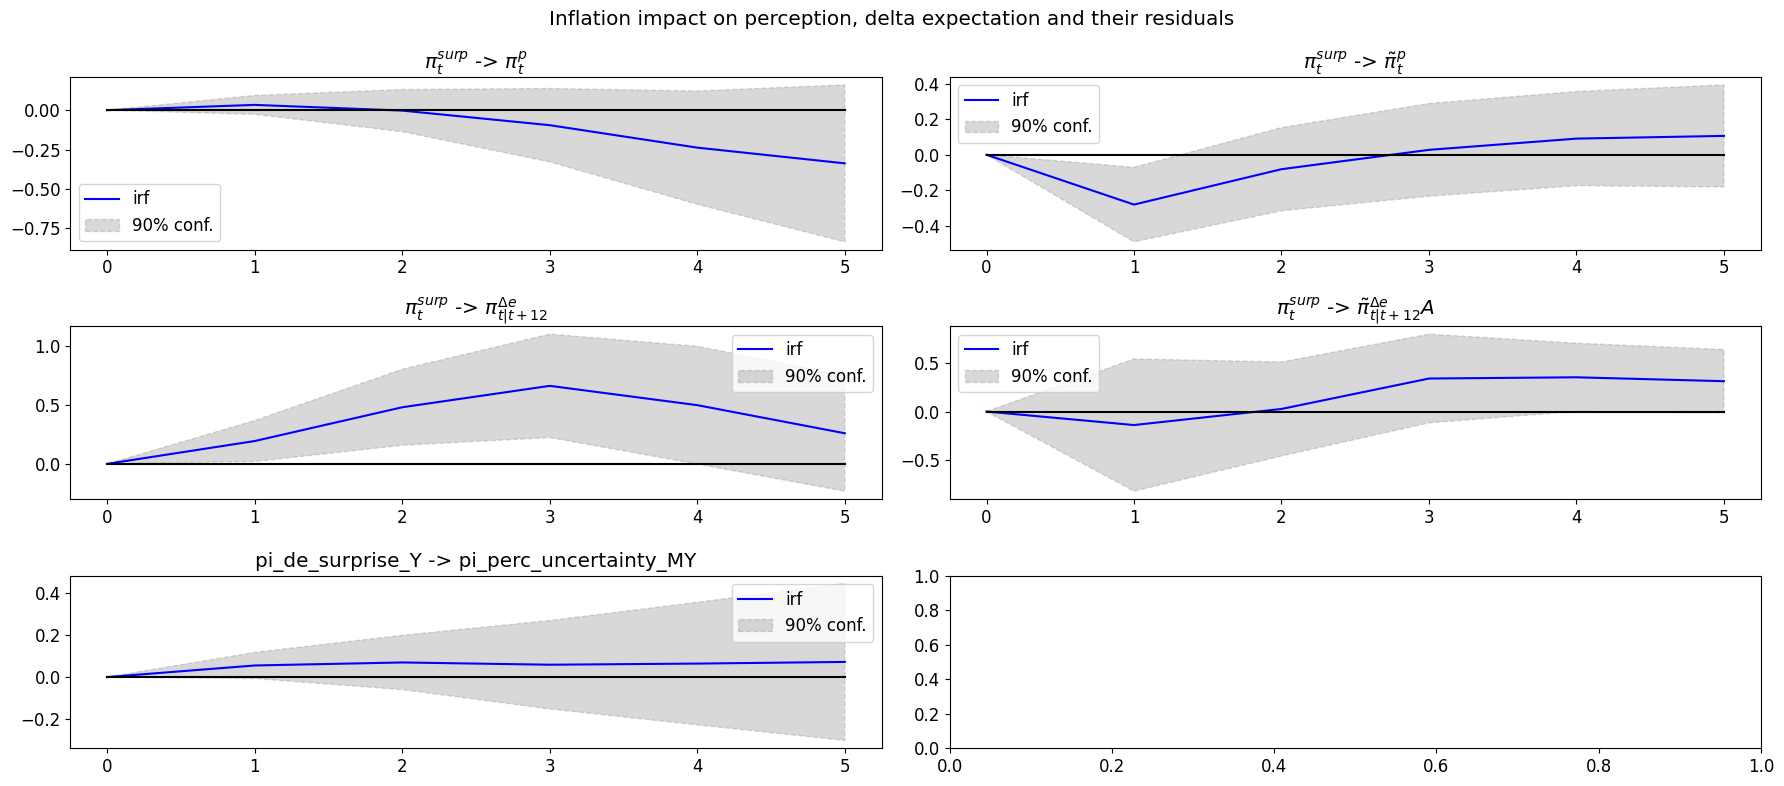

In [55]:
fig = get_multiple_vecm_irfs(lst_vecms1,
                             dict_titles={'pi_de_surprise_Y': "$\pi^{surp}_t$", 
                                          'pi_perc_MY_all_error_act_MY': '$\~{\pi}^p_t$',
                                          "delta_pe_MY_error_act_MY": '$\~{\pi}^{\Delta e}_{t|t+12}A$',
                                          "pi_perc_MY": "$\pi^p_t$", "delta_pe_MY": "$\pi^{\Delta e}_{t|t+12}$",
                                          "pi_perc_MY_error_act": "$\~{\pi}^p_{t}$",},
                             n_cols=2,
                            figsize=(6,4));
fig.suptitle("Inflation impact on perception, delta expectation and their residuals")
fig.tight_layout()
save_fig(fig, "emp_erro_vecm.png")

## VECM error, news, perceived and expexcted

### overview on news and narratives

In [56]:
sub = topics.drop(['M_policy',], axis=1).drop_duplicates().copy().drop('date', axis=1) #.iloc[:300]

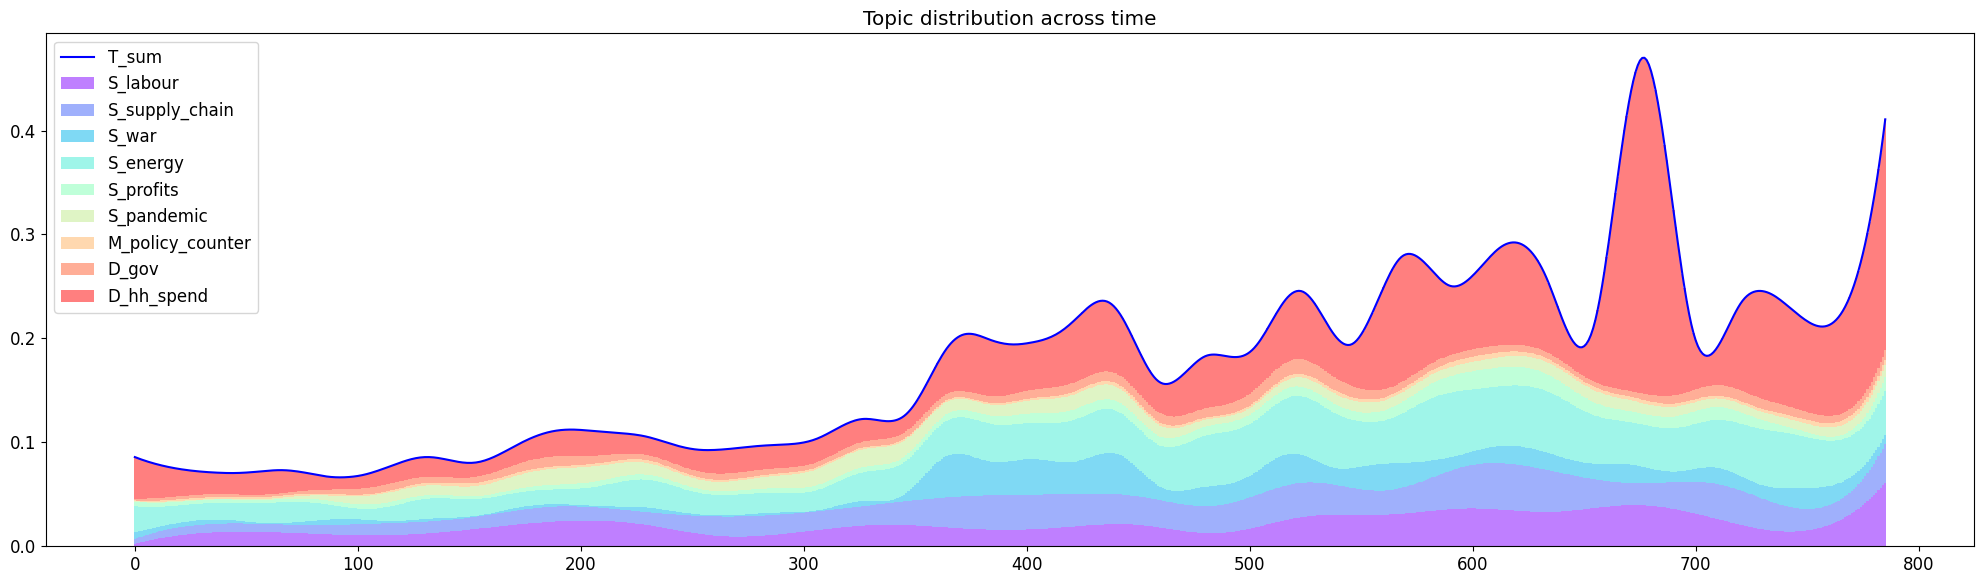

In [57]:
fig, ax = plt_stacked_bar(sub.drop(['D_inflation', 'T_sum', 'T_sum_diff_lag', 'T_sum_diff_lag_M'], axis=1), )

ax.plot(sub.T_sum.values, color='blue', label='T_sum')
ax.set_title("Topic distribution across time")
ax.legend(loc="upper left")
fig.tight_layout()
save_fig(fig, "topics_time.png")

## media and BEI

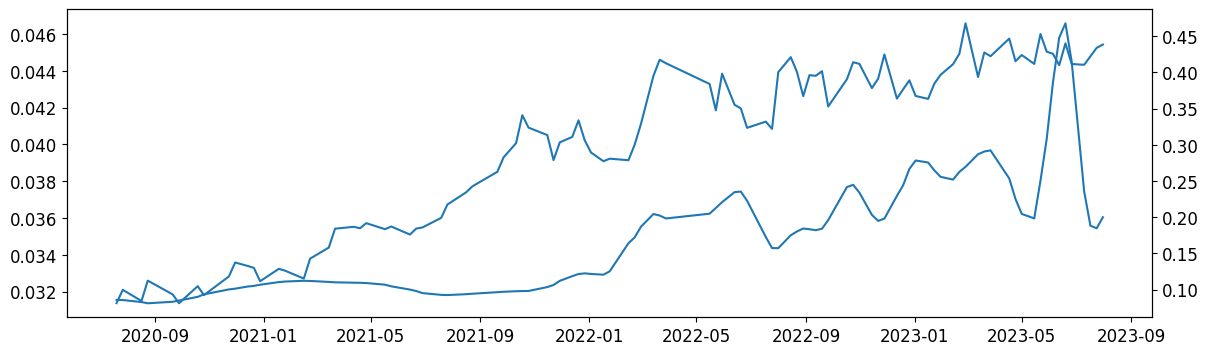

In [58]:
sub = df[['week_recorded', 'bei', 'T_sum']].groupby('week_recorded').last().dropna().copy()
fig, ax = get_fig_subplots()
ax.plot(sub.bei)
ax.twinx().plot(sub.T_sum)

In [59]:
# VAR(sub.diff().dropna()).fit(ic='aic').summary()

### war and inflation as given by hh concern

In [60]:
sub = df[['week_recorded', 'percprob_war', 'percprob_covid']].copy().dropna()
sub = sub.groupby('week_recorded').mean()
sub = pd_join_freq(sub, topics[['S_war', 'S_pandemic']].drop_duplicates() * 500, 'W', keep_left_index=False)
sub = sub.loc[~sub.index.duplicated()]

cols_endog, cols_exog = ['S_war'], ['percprob_war']
_dict = {'percprob_war': 'War perceived', 'percprob_covid': 'Covid-19 perceived', 'S_war': 'War report', 'S_pandemic': 'Covid-19 report'}

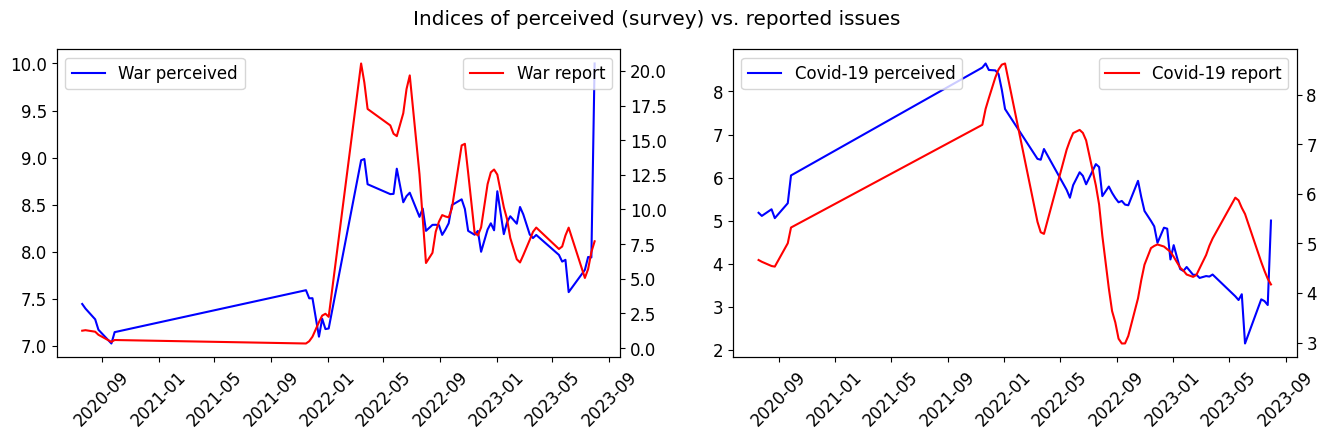

In [61]:
fig, axes = get_fig_subplots(2,2, figsize=(16,2))
lst_cols = [('percprob_war', 'S_war'), ('percprob_covid', 'S_pandemic')]
for idx, ax in enumerate(axes):
    ax.plot(sub[lst_cols[idx][0]], label=_dict[lst_cols[idx][0]], color='blue')
    ax2 = ax.twinx()
    ax2.plot(sub[lst_cols[idx][1]], label=_dict[lst_cols[idx][1]], color='red')
    ax2.legend(loc='upper right')
    ax.legend(loc='upper left')
    ax.tick_params(axis='x', rotation=45)
# axes[0].legend([
fig.suptitle("Indices of perceived (survey) vs. reported issues")
save_fig(fig, "topics_percprob.png")

In [62]:
sub = pd_groupby(df.set_index('date_recorded'), 
                 ['pi_de_surprise_Y', 'delta_pe_MY', 'pi_perc_MY_error_act', 'pi_de_estimate_Y', 'pi_exp_MY', 'pi_perc_MY', 'T_sum']
                 , 'M', 'last').dropna()
sub = pd_join_freq(sub,
             pd_groupby(df.set_index('date_recorded'), ['delta_pe_MY_error_act_MY', 'pi_perc_uncertainty_MY',], 'M', 'mean'),
             'M',
            )
sub['pi_perc_MY_error_act'] /= 100
sub['delta_pe_MY_error_act_MY'] /= 10

## pi perc

In [63]:
cols_endog, cols_exog = ['pi_perc_MY'], ['T_sum', 'pi_de_surprise_Y', 'pi_de_estimate_Y', 'delta_pe_MY']

for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 2) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=4)
print(var_order.aic, var_order.bic)

vecm1 = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=var_order.aic).fit()
# vecm1.summary()

pi_perc_MY ADF p-val: 0.01874377846322591
T_sum ADF p-val: 0.9780580831132807
pi_de_surprise_Y ADF p-val: 0.10964410772978911
pi_de_estimate_Y ADF p-val: 0.5890090275327853
delta_pe_MY ADF p-val: 0.5619457365131322
3


LinAlgError: 5-th leading minor of the array is not positive definite

## pi perc error

In [ ]:
cols_endog, cols_exog = ['pi_perc_MY_error_act'], ['T_sum', 'pi_de_surprise_Y', 'pi_de_estimate_Y', 'pi_perc_MY']

for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 2) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=2)
print(var_order.aic, var_order.bic)

vecm2 = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=var_order.aic).fit()
# vecm2.summary()

## delta pe

In [ ]:
cols_endog, cols_exog = ['delta_pe_MY'], ['T_sum', 'pi_de_surprise_Y', 'pi_de_estimate_Y', 'pi_exp_MY']

for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 2) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=2)
print(var_order.aic, var_order.bic)

vecm3 = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=var_order.aic).fit()

## delta pe error

In [ ]:
cols_endog, cols_exog = ['delta_pe_MY_error_act_MY'], ['T_sum', 'pi_de_surprise_Y', 'pi_de_estimate_Y', 'pi_perc_MY']

for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 2) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=2)
print(var_order.aic, var_order.bic)

vecm4 = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=2).fit()
# vecm4.summary()

## uncertainty

In [ ]:
cols_endog, cols_exog = ['pi_perc_uncertainty_MY'], ['T_sum', 'pi_de_surprise_Y', 'pi_de_estimate_Y']

for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 2) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=3)
print(var_order.aic, var_order.bic)

vecm5 = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=var_order.aic).fit()

## summary

In [ ]:
lst_vecms = [vecm1, vecm2, vecm3, vecm4,  ] #vecm5]
fig = get_multiple_vecm_irfs(lst_vecms,
                             dict_titles={'pi_de_surprise_Y': "$\pi^{surp}_t$", 
                                          "T_sum": "$T^{sum}_t$",
                                          "delta_pe_MY_error_act_MY": '$\~{\pi}^{\Delta e}_{t|t+12}$',
                                          "pi_perc_MY": "$\pi^p_t$", "delta_pe_MY": "$\pi^{\Delta e}_{t|t+12}$",
                                          "pi_perc_MY_error_act": "$\~{\pi}^p_{t}$",
                                          "pi_uncertainty_MY": "$\pi^{pu}_t$",
                                          "pi_de_estimate_Y": "$\pi^{structural}_t$",
                                         },
                             idx_vecm=(0, 3),
                             n_cols=2,
                            figsize=(8,4),);
fig.suptitle("VECM IRF surprise inflation")
fig.tight_layout()
save_fig(fig, "emp_vecm_error_news_pi_struct.png")

In [ ]:
lst_vecms = [vecm1, vecm2, vecm3, vecm4,  ] #vecm5]
fig = get_multiple_vecm_irfs(lst_vecms,
                             dict_titles={'pi_de_surprise_Y': "$\pi^{surp}_t$", 
                                          "T_sum": "$T^{sum}_t$",
                                          "delta_pe_MY_error_act_MY": '$\~{\pi}^{\Delta e}_{t|t+12}$',
                                          "pi_perc_MY": "$\pi^p_t$", "delta_pe_MY": "$\pi^{\Delta e}_{t|t+12}$",
                                          "pi_perc_MY_error_act": "$\~{\pi}^p_{t}$",
                                          "pi_uncertainty_MY": "$\pi^{pu}_t$",
                                         },
                             idx_vecm=(0,2),
                             n_cols=2,
                            figsize=(8,4),);
fig.suptitle("VECM IRF surprise inflation")
fig.tight_layout()
save_fig(fig, "emp_vecm_error_news_pi_surp.png", GRAPHS_DIR)

In [ ]:
fig = get_multiple_vecm_irfs(lst_vecms,
                             dict_titles={'pi_de_surprise_Y': "$\pi^{surp}_t$", 
                                          "T_sum": "$N_t$",
                                          "delta_pe_MY_error_act_MY": '$\~{\pi}^{\Delta e}_{t|t+12}$',
                                          "pi_perc_MY": "$\pi^p_t$", "delta_pe_MY": "$\pi^{\Delta e}_{t|t+12}$",
                                          "pi_perc_MY_error_act": "$\~{\pi}^p_{t}$",
                                          "pi_uncertainty_MY": "$\pi^{pu}_t$",
                                         },
                             n_cols=2,
                            figsize=(8,4),);
fig.suptitle("VECM IRF news index")
fig.tight_layout()
save_fig(fig, "emp_vecm_error_news.png")

In [ ]:
out = get_statsmodels_summary(lst_vecms, is_filt_sig=True)
save_pd_df(out, 'tab_vecm_news_resid.csv', GRAPHS_DIR)


In [ ]:
out

## without inflation

In [66]:
sub = df.groupby('week_recorded')[['pi_exp_WY', 'pi_perc_uncertainty_WY', 
                                   'delta_pe_WY', 'pi_perc_MY_all_error_act_WY', 'pi_perc_WY', 'T_sum']].last().dropna()
sub.shape

(91, 6)

In [67]:
cols_endog, cols_exog = ['pi_perc_uncertainty_WY'], ['T_sum', 'pi_perc_WY', 'delta_pe_WY']

for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 5) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=3)
print(var_order.aic, var_order.bic)

vecm = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=1).fit()
# vecm.summary()

pi_perc_uncertainty_WY ADF p-val: 5.592176077492414e-06
T_sum ADF p-val: 0.9713187460871008
pi_perc_WY ADF p-val: 0.01849634003386648
delta_pe_WY ADF p-val: 0.8976540313298764
3
3 1


In [68]:
# irf = vecm.irf()
# irf.plot(figsize=(15,10))
# plt.tight_layout()

## FECVD

Same analysis as Dräger (2015) as VAR to analyse:
$$ \hat{X}_t = \Gamma \hat{X}_{t-1} + u_t $$ 
where
$$X_t = (\hat{\pi}_t, \hat{\pi}^p_t, \hat{\pi}^e_{t-12}, \hat{N}_t), \quad \mbox{where} \quad \hat{z}_t = z_t - z_{t-1} $$

In [203]:
sub = pd_groupby(df.set_index('date_recorded'), 
                 [ 'pi_de_surprise_Y', 'pi_de_estimate_Y', 'pi_exp_MY', 'pi_perc_MY', 'T_sum'], 'M', 'last').dropna()
sub_d = sub.diff().dropna().copy()

In [204]:
var = VAR(sub).fit(ic='aic')
# var.summary()

In [205]:
# var.fevd().plot()
# plt.tight_layout();

# Micro analysis

In [75]:
df_micro = pd_join_freq(
    hhp.set_index('date_recorded')[[
        'date_forecast', 'pi_perc', 'pi_perc_WY', 'id', 'hhinc_midpoint', 'debt', 'is_homeown', 'wealth_bank', 'is_unempl',
        'pinc_midpoint', 'eduwork', 'profession', 'delta_pe', 'pi_exp', 'hhinc',
    ]].copy(),
    pi[['pi_de_Y',  'pi_de_surprise_Y', 'pi_de_estimate_Y',]],
    'M',
    keep_left_index=True).copy()
df_micro = pd_join_freq(
    df_micro, 
    topics[['T_sum', 'T_sum_diff_lag']].drop_duplicates(), 
    "D", keep_left_index=True, how='left').sort_index()
df_micro['week_recorded'] = df_micro.date_forecast.dt.to_period('W').dt.to_timestamp()

In [76]:
df_micro['pi_perc_error'] = df_micro['pi_perc'] - df_micro.pi_de_Y
df_micro['delta_pe_error'] = df_micro['delta_pe'] - df_micro.pi_de_Y

In [77]:
_ = df[['pi_de_Y', 'pi_perc_WY']].apply(lambda x: x.iloc[1] - x.iloc[0], axis=1).copy().rename('pi_perc_error')
df['pi_perc_error'] = _

In [78]:
DICT_PARSE_COLS.update(
    {
        'T_pca_sum': float,
        'T_pca_sum_diff': float,
        'pi_de_surprise_Y': float,
        'pi_de_estimate_Y': float,
        'delta_pe_error': float,
        'hhinc_midpoint': 'categoryO',
    }
)

In [79]:
df_micro = pd_df_astype(df_micro, DICT_PARSE_COLS)

## panel structure sparsity and distance analysis

In [80]:
ind_cols = ['id', 'week_recorded']
sub = df[['pi_perc'] + ind_cols].copy().reset_index(drop=True).drop_duplicates()

filt = sub.groupby(ind_cols).pi_perc.last().unstack().count(axis=1) > 7
sub = sub.loc[sub.id.isin(list(filt[filt].index))].set_index(ind_cols).sort_index()
sub = sub.dropna()
filt.sum()

377

In [81]:
dist = df.groupby('id')[
    ['hhinc_midpoint', 'pi_perc_error', 'debt', 'wealth_bank', 'savings_planned', 'eduschool', 'hhsize', 'ecbtrust']
                       ].last().astype(float)

dist = dist.loc[sub.index.get_level_values(0)]
dist = dist.loc[~dist.index.duplicated()]
dist = scipy.spatial.distance.cdist(dist, dist)

dist[np.isnan(dist)] = np.array(list([0] * np.isnan(dist).sum()))
dist = dist.mean(axis=0)

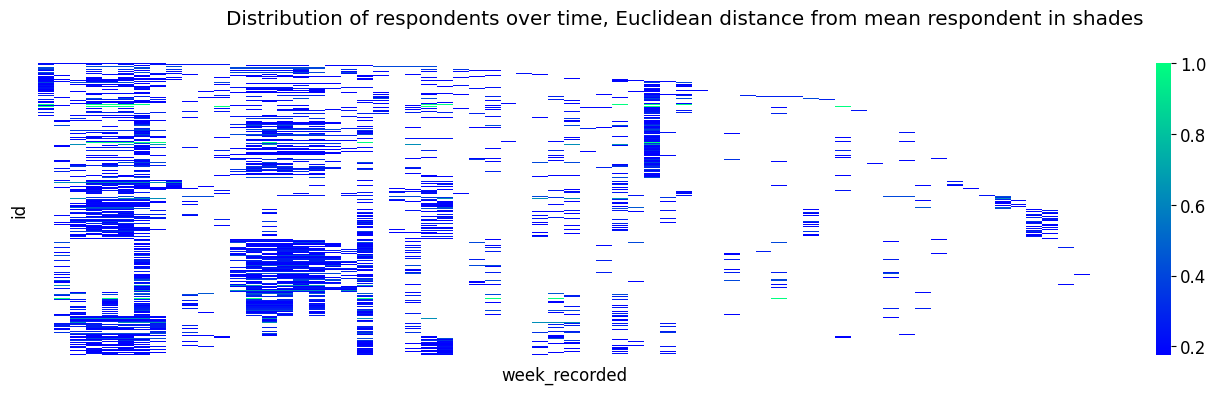

In [82]:
A = ~sub.unstack().isna()
A = (A * ((dist - dist.min()) / (dist.max() - dist.min()))[:, None]).replace({0: np.nan})
A.columns = A.columns.get_level_values(1)

# fig = plt.figure(figsize=(16,5))
fig, ax = get_fig_subplots()
fig.suptitle('Distribution of respondents over time, Euclidean distance from mean respondent in shades')
fig.tight_layout()
sns.heatmap(A, xticklabels=False, yticklabels=False, ax=ax, cmap='winter')
save_fig(fig, "pols_dist_matrix.png")

## POLS: How do news affect inflation perception on an individual level?

Investigate the effect of news $N_t$ on inflation perception $\pi^p_{i,t}$:
$$ \pi^p_{i,t} = \alpha_i + \beta N_t + \gamma X_{i,t} + \epsilon_{i,t} $$

In [83]:
cols = ['T_sum_diff_lag', 'hhinc_midpoint', 'pi_de_surprise_Y', 'pi_de_estimate_Y', 'is_unempl',]  #'debt',]
ind_cols = ['id', 'week_recorded']
dep_col = ['pi_perc']

In [84]:
sub = df_micro[ind_cols + cols + dep_col].copy().reset_index(drop=True)
filt = sub.groupby(ind_cols)[dep_col + cols].last()
filt = filt.dropna().reset_index().groupby('id').count().min(axis=1) > 5
sub = sub.loc[sub.id.isin(set(filt[filt].index))].set_index(ind_cols).sort_index().dropna()
sub = pd_df_astype(sub)

sub.shape, filt.sum()

((2960, 6), 473)

In [85]:
m_fe1 = PanelOLS(sub[dep_col], sub[cols], entity_effects=True, ).fit(cov_type='clustered', cluster_entity=True)
m_re = RandomEffects(sub[dep_col], sub[cols]).fit()

In [86]:
dist, filt = get_cooks_distance(sub[cols].values.astype(float), m_fe1.resids.values, flt_largest_perc=90.)
sub2 = sub.drop(sub.loc[filt].index.get_level_values(0))
m_fe12 = PanelOLS(sub2[dep_col], sub2[cols],
                   entity_effects=True, drop_absorbed=True, check_rank=False).fit(cov_type="clustered", cluster_entity=True)

C:\Users\LukasGrahl\AppData\Local\Temp\ipykernel_14200\3742255664.py:4: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

hhinc_midpoint.12000.0

  entity_effects=True, drop_absorbed=True, check_rank=False).fit(cov_type="clustered", cluster_entity=True)


In [87]:
out = get_statsmodels_summary([m_fe1, m_fe12], ['print'], seperator=" ", is_filt_sig=True)
out

print                     
                                    pi_perc            pi_perc_1
T_sum_diff_lag           -0.287 *** [-3.86]   -0.128 ** [-2.166]
hhinc_midpoint.2250.0       -0.01  [-0.679]   -0.024 ** [-1.969]
is_unempl                  -0.007  [-0.735]   -0.008 ** [-2.292]
pi_de_estimate_Y         1.619 *** [46.332]   1.707 *** [64.431]
pi_de_surprise_Y       -0.648 *** [-18.329]  -0.65 *** [-26.529]
N                                    2960.0               1797.0
R^2                                   0.496                0.742
R^2 between                           0.793                0.671

In [88]:
# plt.scatter(m_fe.predict().values, m_fe.resids.values)

In [89]:
# H0: Homoscedasticity is present
_ = sm.add_constant(pd.concat([m_fe1.resids, sub[cols]], axis=1))
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, het_breuschpagan(_[['residual']], _.drop('residual', axis=1)))))

{'LM-Stat': 9.731528055959817, 'LM p-val': 0.08320964876006931, 'F-Stat': 1.9487673173256976, 'F p-val': 0.08317198492149712}


In [90]:
durbin_watson_test_results = durbin_watson(m_fe1.resids) 
print(durbin_watson_test_results)

2.0038560253492794


In [91]:
# H0: RE is to be preferred
hausman_results = hausman(m_fe1, m_re)
print('chi-Squared: ' + str(hausman_results[0]))
print('degrees of freedom: ' + str(hausman_results[1]))
print('p-Value: ' + str(hausman_results[2]))

chi-Squared: 14.719913142667025
degrees of freedom: 16
p-Value: 0.545240206035982


# Exp 2

Influence of news on future change in inflation $\pi^e_{i,t} - \pi^p_{i,t}$
$$ \pi^e_{i,t} - \pi^p_{i,t} = \alpha_i + \beta N_t + \gamma X_{i,t} + \epsilon_{i,t} $$

In [92]:
cols = ['T_sum_diff_lag', 'hhinc_midpoint', 'pi_de_surprise_Y', 'pi_de_estimate_Y', 'debt', 'is_unempl', 'wealth_bank',]  #'debt',]
ind_cols = ['id', 'week_recorded']
dep_col = ['delta_pe']

In [93]:
sub = df_micro[ind_cols + cols + dep_col].copy().reset_index(drop=True)
filt = sub.groupby(ind_cols)[dep_col + cols].last()
filt = filt.dropna().reset_index().groupby('id').count().min(axis=1) > 3
sub = sub.loc[sub.id.isin(set(filt[filt].index))].set_index(ind_cols).sort_index().dropna()
sub = pd_df_astype(sub)
sub.shape, filt.sum()

((2982, 8), 715)

In [94]:
m_fe2 = PanelOLS(sub[dep_col], sub[cols], entity_effects=True).fit(cov_type='clustered', cluster_entity=True)
m_re = RandomEffects(sub[dep_col], sub[cols]).fit()
# print(m_fe2)

In [95]:
dist, filt = get_cooks_distance(sub[cols].values.astype(float), m_fe2.resids.values, flt_largest_perc=80.)
sub2 = sub.drop(sub.loc[filt].index.get_level_values(0))
m_fe22 = PanelOLS(sub2[dep_col], sub2[cols],
                   entity_effects=True, drop_absorbed=True, check_rank=False).fit(cov_type="clustered", cluster_entity=True)

C:\Users\LukasGrahl\AppData\Local\Temp\ipykernel_14200\3177373305.py:4: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

debt.9.0

  entity_effects=True, drop_absorbed=True, check_rank=False).fit(cov_type="clustered", cluster_entity=True)


In [96]:
get_statsmodels_summary([m_fe2, m_fe22], ['print'], seperator=" ", is_filt_sig=True)

print                      
                                     delta_pe            delta_pe_1
hhinc_midpoint.2750.0        0.009 ** [2.452]     0.009 *** [8.838]
is_unempl                  -0.004 ** [-2.202]   -0.004 *** [-3.118]
hhinc_midpoint.9000.0       0.011 *** [2.659]     0.011 *** [6.391]
hhinc_midpoint.750.0           0.007 * [1.88]     0.014 *** [5.621]
hhinc_midpoint.7000.0       0.011 *** [2.965]      0.011 *** [6.98]
hhinc_midpoint.5500.0        0.01 *** [2.764]     0.011 *** [7.304]
hhinc_midpoint.4250.0       0.011 *** [2.953]      0.011 *** [9.04]
hhinc_midpoint.3750.0        0.009 ** [2.559]      0.01 *** [8.028]
hhinc_midpoint.3250.0       0.011 *** [2.959]     0.011 *** [9.887]
pi_de_estimate_Y           0.706 *** [79.958]    0.759 *** [67.353]
pi_de_surprise_Y        -0.756 *** [-104.121]  -0.797 *** [-89.998]
hhinc_midpoint.1750.0        0.008 ** [2.343]     0.011 *** [10.79]
hhinc_midpoint.1250.0        0.009 ** [2.446]    0.012 *** [12.125]
hhinc_midpoint.12000.0         0.01 ** [2.12]     0.006 *** [3.723]
debt.8.0                       0.001  [0.893]     0.004 *** [2.662]
debt.4.0                   -0.002 ** [-2.211]       -0.001  [-1.31]
T_sum_diff_lag             2.217 *** [37.911]     2.536 *** [33.03]
hhinc_midpoint.2250.0        0.008 ** [2.336]    0.009 *** [11.202]
R^2 between                            -5.578                -6.771
R^2                                     0.785                 0.898
N                                      2982.0                1275.0

In [97]:
# H0: Homoscedasticity is present
_ = sm.add_constant(pd.concat([m_fe2.resids, sub[cols]], axis=1))
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, het_breuschpagan(_[['residual']], _.drop('residual', axis=1)))))

{'LM-Stat': 43.181886376026625, 'LM p-val': 3.076435191493403e-07, 'F-Stat': 6.242690823174869, 'F p-val': 2.77045765767781e-07}


In [98]:
durbin_watson_test_results = durbin_watson(m_fe2.resids) 
print(durbin_watson_test_results)

2.3842923018574034


In [99]:
# H0: RE is to be preferred
hausman_results = hausman(m_fe2, m_re)
print('chi-Squared: ' + str(hausman_results[0]))
print('degrees of freedom: ' + str(hausman_results[1]))
print('p-Value: ' + str(hausman_results[2]))

chi-Squared: 41.04889561436247
degrees of freedom: 34
p-Value: 0.18898709599459806


# Exp 3

Influence of news on expectation:
$$ \pi^e_{i,t} = \alpha_i + \beta N_t + \gamma X_{i,t} + \epsilon_{i,t} $$

In [100]:
# cols = ['T_sum_diff_lag', 'hhinc_midpoint', 'pi_de_Y',]# 'debt',] # 'is_unempl', ] #'wealth_bank'] #, 'eduwork']
cols = ['T_sum_diff_lag', 'hhinc_midpoint', 'pi_de_surprise_Y', 'pi_de_estimate_Y', ]
ind_cols = ['id', 'week_recorded']
dep_col = ['pi_exp']

In [101]:
sub = df_micro[ind_cols + cols + dep_col].copy().reset_index(drop=True)
filt = sub.groupby(ind_cols)[dep_col + cols].last()
filt = filt.dropna().reset_index().groupby('id').count().min(axis=1) > 5
sub = sub.loc[sub.id.isin(set(filt[filt].index))].set_index(ind_cols).sort_index().dropna()
sub = pd_df_astype(sub)
sub.shape, filt.sum()

((29619, 5), 4300)

In [102]:
m_fe3 = PanelOLS(sub[dep_col], sub[cols], entity_effects=True).fit(cov_type='clustered', cluster_entity=True)
m_re = RandomEffects(sub[dep_col], sub[cols]).fit()

In [103]:
dist, filt = get_cooks_distance(sub[cols].values.astype(float), m_fe3.resids.values, flt_largest_perc=90.)
sub2 = sub.drop(sub.loc[filt].index.get_level_values(0))
m_fe32 = PanelOLS(sub2[dep_col], sub2[cols],
                   entity_effects=True, drop_absorbed=True, check_rank=False).fit(cov_type="clustered", cluster_entity=True)

In [104]:
get_statsmodels_summary([m_fe3, m_fe32], ['print'], seperator=" ", is_filt_sig=True)

print                     
                                    pi_exp             pi_exp_1
T_sum_diff_lag         -0.199 *** [-6.784]   -0.205 *** [-8.93]
hhinc_midpoint.2250.0     -0.003  [-0.805]   -0.005 ** [-2.253]
hhinc_midpoint.2750.0      -0.003  [-0.82]   -0.005 ** [-2.561]
hhinc_midpoint.3250.0     -0.003  [-0.706]   -0.005 ** [-2.201]
hhinc_midpoint.3750.0     -0.002  [-0.595]   -0.004 ** [-1.972]
hhinc_midpoint.4250.0     -0.004  [-0.854]   -0.005 ** [-2.229]
hhinc_midpoint.5500.0     -0.003  [-0.819]   -0.005 ** [-2.134]
hhinc_midpoint.750.0      -0.003  [-0.601]  -0.006 *** [-2.581]
pi_de_estimate_Y        0.983 *** [72.192]   1.089 *** [99.872]
pi_de_surprise_Y         0.18 *** [13.707]    0.133 *** [12.84]
N                                  29619.0              16826.0
R^2                                  0.444                 0.68
R^2 between                          0.808                0.846

In [105]:
# H0: Homoscedasticity is present
_ = sm.add_constant(pd.concat([m_fe3.resids, sub[cols]], axis=1))
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, het_breuschpagan(_[['residual']], _.drop('residual', axis=1)))))

{'LM-Stat': 133.96010088206506, 'LM p-val': 5.5375183496182e-28, 'F-Stat': 33.636502113400134, 'F p-val': 4.810430376888195e-28}


In [106]:
durbin_watson_test_results = durbin_watson(m_fe3.resids) 
print(durbin_watson_test_results)

1.9851732576410788


In [107]:
# H0: RE is to be preferred
hausman_results = hausman(m_fe3, m_re)
print('chi-Squared: ' + str(hausman_results[0]))
print('degrees of freedom: ' + str(hausman_results[1]))
print('p-Value: ' + str(hausman_results[2]))

chi-Squared: 52.75638146924047
degrees of freedom: 15
p-Value: 4.232641067169811e-06


## Exp 4

In [108]:
cols = ['T_sum_diff_lag', 'hhinc_midpoint', 'pi_de_surprise_Y', 'pi_de_estimate_Y', ] #'debt', 'is_unempl', 'wealth_bank',]  #'debt',]
ind_cols = ['id', 'week_recorded']
dep_col = ['pi_perc_error']

In [109]:
sub = df_micro[ind_cols + cols + dep_col].copy().reset_index(drop=True)
filt = sub.groupby(ind_cols)[dep_col + cols].last()
filt = filt.dropna().reset_index().groupby('id').count().min(axis=1) > 4
sub = sub.loc[sub.id.isin(set(filt[filt].index))].set_index(ind_cols).sort_index().dropna()
sub.shape, filt.sum()

((8055, 5), 1492)

In [110]:
m_fe4 = PanelOLS(sub[dep_col], sub[cols], entity_effects=True).fit(cov_type='clustered', cluster_entity=True)
m_re = RandomEffects(sub[dep_col], sub[cols]).fit()

In [111]:
# plt.scatter(m_fe4.predict().values, m_fe4.resids.values)

In [112]:
# H0: Homoscedasticity is present
_ = sm.add_constant(pd.concat([m_fe4.resids, sub[cols]], axis=1))
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, het_breuschpagan(_[['residual']], _.drop('residual', axis=1)))))

{'LM-Stat': 53.327093922171194, 'LM p-val': 7.279080972342227e-11, 'F-Stat': 13.412292376616799, 'F p-val': 6.769040249195835e-11}


In [113]:
durbin_watson_test_results = durbin_watson(m_fe4.resids) 
print(durbin_watson_test_results)

2.1854819389607507


In [114]:
# H0: RE is to be preferred
hausman_results = hausman(m_fe4, m_re)
print('chi-Squared: ' + str(hausman_results[0]))
print('degrees of freedom: ' + str(hausman_results[1]))
print('p-Value: ' + str(hausman_results[2]))

chi-Squared: 19.294110136226617
degrees of freedom: 15
p-Value: 0.20071428682485978


## Exp 5

In [115]:
cols = ['T_sum_diff_lag', 'hhinc_midpoint', 'pi_de_surprise_Y', 'pi_de_estimate_Y', ] #'debt', 'is_unempl', 'wealth_bank',]  #'debt',]
ind_cols = ['id', 'week_recorded']
dep_col = ['delta_pe_error']

In [116]:
sub = df_micro[ind_cols + cols + dep_col].copy().reset_index(drop=True)
filt = sub.groupby(ind_cols)[dep_col + cols].last()
filt = filt.dropna().reset_index().groupby('id').count().min(axis=1) > 4
sub = sub.loc[sub.id.isin(set(filt[filt].index))].set_index(ind_cols).sort_index().dropna()
sub.shape, filt.sum()

((45794, 5), 7279)

In [117]:
sub = sub.loc[~sub.duplicated()]

In [118]:
m_fe5 = PanelOLS(sub[dep_col], sub[cols], entity_effects=True).fit(cov_type='clustered', cluster_entity=True)
m_re = RandomEffects(sub[dep_col], sub[cols]).fit()
# print(m_fe5)

In [119]:
# plt.scatter(m_fe.predict().values, m_fe.resids.values)

In [120]:
# H0: Homoscedasticity is present
_ = sm.add_constant(pd.concat([m_fe5.resids, sub[cols]], axis=1))
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, het_breuschpagan(_[['residual']], _.drop('residual', axis=1)))))

{'LM-Stat': 40.1161500548235, 'LM p-val': 4.0955041155242976e-08, 'F-Stat': 10.153400377756073, 'F p-val': 3.676614306987792e-08}


In [121]:
durbin_watson_test_results = durbin_watson(m_fe5.resids) 
print(durbin_watson_test_results)

2.3733566765306287


In [122]:
# H0: RE is to be preferred
hausman_results = hausman(m_fe5, m_re)
print('chi-Squared: ' + str(hausman_results[0]))
print('degrees of freedom: ' + str(hausman_results[1]))
print('p-Value: ' + str(hausman_results[2]))

chi-Squared: 60.15484977939887
degrees of freedom: 15
p-Value: 2.3720837561939567e-07


## summary

In [123]:
lst_fes = [m_fe1, m_fe2, m_fe3, m_fe4, m_fe5]
out = get_statsmodels_summary(lst_fes, seperator=" ", is_filt_sig=True)
save_pd_df(out, 'tab_pols.csv', GRAPHS_DIR)

In [124]:
out

,delta_pe,delta_pe_error,pi_exp,pi_perc,pi_perc_error
hhinc_midpoint.2750.0,0.009 ** [2.452],0.004 [0.937],-0.003 [-0.82],-0.006 [-0.447],0.002 [0.17]
is_unempl,-0.004 ** [-2.202],NaN,NaN,-0.007 [-0.735],NaN
hhinc_midpoint.9000.0,0.011 *** [2.659],0.002 [0.556],-0.002 [-0.416],-0.004 [-0.261],0.007 [0.664]
hhinc_midpoint.7000.0,0.011 *** [2.965],0.007 * [1.798],-0.003 [-0.699],-0.004 [-0.283],0.004 [0.385]
hhinc_midpoint.5500.0,0.01 *** [2.764],0.007 * [1.682],-0.003 [-0.819],-0.006 [-0.404],0.005 [0.503]
hhinc_midpoint.4250.0,0.011 *** [2.953],0.007 [1.56],-0.004 [-0.854],-0.006 [-0.374],0.004 [0.364]
hhinc_midpoint.3750.0,0.009 ** [2.559],0.003 [0.762],-0.002 [-0.595],-0.004 [-0.279],0.002 [0.239]
hhinc_midpoint.3250.0,0.011 *** [2.959],0.004 [0.891],-0.003 [-0.706],-0.006 [-0.386],0.004 [0.41]
pi_de_estimate_Y,0.706 *** [79.958],-1.077 *** [-38.988],0.983 *** [72.192],1.619 *** [46.332],0.116 *** [4.783]
pi_de_surprise_Y,-0.756 *** [-104.121],-0.995 *** [-40.972],0.18 *** [13.707],-0.648 *** [-18.329],-1.156 *** [-52.196]
